# Vendas

## Pipeline

Etapa 01: Instalar e Importar as Bibliotecas

Etapa 02: Obter o Datasource

Etapa 03: Exibir os Dados, Metadados e Estatísticas

Etapa 04: Extract, Transform, Load (ETL)

Etapa 05: Exploratory Data Analysis (EDA)

Etapa 06: Identificação dos Outliers

Etapa 07: Preprocessamento de Dados (Regras, Codificação e Normalização)

Etapa 08: Redução da Dimensionalidade

Etapa 09: Clusterização

Etapa 10: Rotulagem

Etapa 11: Preparação dos Dados para o Aprendizado de Máquina

Etapa 12: Escolha dos Hiperparâmetros dos Modelos

Etapa 13: Competição de Modelos

Etapa 14: Produção (Deploy)

## Definição dos Atributos

In [ ]:
# ID_Venda: Este campo é um identificador único para cada transação realizada, funcionando como um número de referência para a venda. Ele ajuda a diferenciar e rastrear cada venda individualmente no dataset.
# Data_Venda: Indica a data em que a venda foi realizada. Esse campo permite análises temporais, como tendências de vendas ao longo de períodos específicos ou sazonalidade.
# ID_Produto: Este é o identificador único de cada produto vendido. Ele permite a associação de transações com produtos específicos e possibilita análises de desempenho de cada produto.
# Quantidade: Representa o número de unidades de um determinado produto que foram vendidas na transação. Esse campo pode ajudar a entender volumes de vendas e padrões de consumo por transação. Neste dataset, podem haver valores nulos (ausentes) ou outliers (quantidades fora do padrão usual), que precisam de atenção em análises.
# Preco_Unitario: Indica o preço de cada unidade do produto no momento da venda. Esse campo pode ter valores nulos (preço não informado) ou outliers (preços muito elevados) e é fundamental para calcular o valor total da venda.
# ID_Cliente: Identificador único do cliente que realizou a compra. Esse campo permite análises centradas nos clientes, como frequência de compra e valor gasto.
# Valor_Total: Calcula o valor total da venda, considerando o número de unidades vendidas, o preço unitário, o desconto aplicado e o valor do frete. Este campo é útil para entender a receita total gerada por cada venda.
# Canal_Venda: Mostra o canal de venda, ou seja, onde ou como o cliente comprou o produto: Online, a venda foi feita pela internet; Loja Física, a venda foi realizada em uma loja física; Distribuidor, a venda foi feita por meio de um distribuidor.
# Forma_Pagamento: Descreve o método de pagamento utilizado pelo cliente, com as opções: Cartão de Crédito; Boleto; Transferência Bancária; Dinheiro.
# Desconto: Indica o percentual de desconto aplicado na venda. Esse campo mostra quanto foi descontado do valor total e permite análise de eficácia de promoções e incentivos para vendas.
# Frete: Custo adicional para envio do produto ao cliente. Esse campo reflete o custo logístico e pode influenciar o preço final percebido pelo cliente, além de ajudar na avaliação do impacto dos custos de envio na receita.
# Regiao: A região geográfica do cliente, que pode ser uma das seguintes: **Norte, Nordeste, Centro-Oeste, Sudeste** ou **Sul**. Esse campo é útil para análises geográficas e segmentação regional de vendas, além de ajudar a entender a demanda por área.
# Categoria_Produto: Categoria do produto vendido, com opções como **Eletrônicos, Roupas, Alimentos, Móveis** e **Cosméticos**. Este campo ajuda a organizar os produtos por tipo e permite análises de popularidade e desempenho de cada categoria.

### Geração do Dataset Completo

In [ ]:
# Atribuir ID do arquivo no Google Drive
file_id = '1VKF9VVqynVVg08p2ctogdFJizcPRmyR8'
dataset_url = f'https://drive.google.com/uc?id={file_id}'

# Definir nome do arquivo
output_path = 'vendas.csv'

# Baixar o arquivo usando gdown
gdown.download(dataset_url, output_path, quiet=False)

# Carregar o arquivo CSV em um DataFrame, especificando o separador como ponto-e-vírgula
dataset = pd.read_csv(output_path, sep=';')

# Criar uma cópia do dataset
dataset_copy = dataset.copy()

# Preencher valores nulos de colunas numéricas com a média
for column in dataset_copy.select_dtypes(include=np.number):
  if dataset_copy[column].isnull().any():
    dataset_copy[column] = dataset_copy[column].fillna(dataset_copy[column].mean())

# Preencher valores nulos de colunas categóricas com a moda
for column in dataset_copy.select_dtypes(include=['object']):
  if dataset_copy[column].isnull().any():
    dataset_copy[column] = dataset_copy[column].fillna(dataset_copy[column].mode()[0])

# Atualizar o dataset original com a cópia modificada
dataset = dataset_copy

# Selecionar apenas colunas numéricas
numeric_cols = dataset.select_dtypes(include='number')

# Inicializar contador de outliers
outlier_counts = 0
total_values = numeric_cols.size

# Detectar outliers usando o método IQR para cada coluna numérica
for col in numeric_cols.columns:
    Q1 = numeric_cols[col].quantile(0.25)
    Q3 = numeric_cols[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar outliers
    col_outliers = numeric_cols[(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)][col].count()
    outlier_counts += col_outliers
    print(f"Coluna '{col}' - Outliers: {col_outliers}")

# Calcular o percentual de contaminação de outliers no dataset
outlier = (outlier_counts / total_values)
print("")
print(f"Percentual de contaminação de outliers no dataset: {outlier*100:.2f}%")
print(f"Valor de contaminação de outliers no dataset: {outlier:.4f}")

# Selecionar apenas colunas numéricas para a detecção de outliers
numeric_data = dataset.select_dtypes(include='number')

# Configurar e aplicar o Isolation Forest com contaminação
iso_forest = IsolationForest(contamination=outlier, random_state=42)
outlier_labels = iso_forest.fit_predict(numeric_data)

# Adicionar os rótulos de outliers ao dataset
dataset['is_outlier'] = outlier_labels

# Filtrar apenas os outliers (rótulo -1)
outliers = dataset[dataset['is_outlier'] == -1]

# Exibir os dados que são outliers
print("Dados identificados como outliers:")
print(outliers.to_string())

# Exibir a quantidade de outliers detectados
outlier_count = len(outliers)
print(f"\nTotal de outliers: {outlier_count}")

# Remover os outliers
try:
    dataset = dataset[dataset['is_outlier'] == 1].drop(columns=['is_outlier'])
except Exception as e:
    print(f"Ocorreu um erro: {e}")

# Remover a coluna 'Outlier' do dataset
if 'Outlier' in dataset.columns:
  dataset = dataset.drop('Outlier', axis=1)

# Remover a coluna 'is_outlier' do dataset
if 'is_outlier' in dataset.columns:
  dataset = dataset.drop('is_outlier', axis=1)

# Definir a coluna meta (primeira coluna)
meta_column = dataset.columns[0]

# Definir as colunas de features (demais colunas)
feature_columns = dataset.columns[1:]

# Criar o dataset de meta e features
y = dataset[meta_column]
X = dataset[feature_columns]

# Label encoding
for column in dataset.select_dtypes(include=['object']):
  # Criar um objeto LabelEncoder
  le = LabelEncoder()

  # Aplicar Label Encoding na coluna original
  dataset[column + '_encoded'] = le.fit_transform(dataset[column])

# MinMaxScaler
scaler = MinMaxScaler()

# Iterar pelas colunas numéricas do datasetx
for column in dataset.select_dtypes(include=['number']):
  # Aplicar MinMaxScaler na coluna atual e criar um novo campo com o sufixo "_minmax"
  dataset[column + '_minmax'] = scaler.fit_transform(dataset[[column]])

# Verificar se as colunas 'pc1' e 'pc2' já existem no dataset
if 'pc1' not in dataset.columns or 'pc2' not in dataset.columns:
  # Selecionar apenas as colunas com sufixo '_minmax'
  minmax_columns = [col for col in dataset.columns if col.endswith('_minmax')]
  dataset_minmax = dataset[minmax_columns]

  # Substituir valores NaN por 0
  dataset_minmax = dataset_minmax.fillna(0)

  # Aplicar PCA com 2 componentes principais
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(dataset_minmax)

  # Criar as colunas 'pc1' e 'pc2' no dataset original com os componentes principais
  dataset['pc1'] = principal_components[:, 0]
  dataset['pc2'] = principal_components[:, 1]
else:
  # Se as colunas 'pc1' e 'pc2' já existem, atualizar os valores com os novos componentes principais
  minmax_columns = [col for col in dataset.columns if col.endswith('_minmax')]
  dataset_minmax = dataset[minmax_columns]

  # Substituir valores NaN por 0
  dataset_minmax = dataset_minmax.fillna(0)

  # Aplicar PCA com 2 componentes principais
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(dataset_minmax)

  # Atualizar os valores das colunas 'pc1' e 'pc2'
  dataset['pc1'] = principal_components[:, 0]
  dataset['pc2'] = principal_components[:, 1]

# Exibir o dataset sem os outliers
print("Dataset sem os outliers:")
print(dataset.head().to_string())

# Exibir quantidade de dados nulos
print("\nValores nulos após a substituição:")
print(dataset.isnull().sum())

# Exibir informações gerais do dataset
print("\nInformações Gerais do Dataset:")
print(dataset.info())

print(f"Coluna meta: {meta_column}")
print(f"Colunas de features: {feature_columns.tolist()}")

## Etapa 1: Instalar e Importar as Bibliotecas

In [2]:
# Importar bibliotecas
try:
  import gdown
except ImportError:
  !pip install gdown
  import gdown
try:
  import lightgbm
except ImportError:
  !pip install lightgbm
  import lightgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.covariance import EllipticEnvelope
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Etapa 2: Obter o Datasource

In [3]:
# Atribuir ID do arquivo no Google Drive
file_id = '1hiIZlzVllUgfTgx4yLkiE3IqxqcawGA4'
dataset_url = f'https://drive.google.com/uc?id={file_id}'

# Definir nome do arquivo
output_path = 'vendas.csv'

# Baixar o arquivo usando gdown
gdown.download(dataset_url, output_path, quiet=False)

# Carregar o arquivo CSV em um DataFrame, especificando o separador como ponto-e-vírgula
dataset = pd.read_csv(output_path, sep=';')

Downloading...
From: https://drive.google.com/uc?id=1hiIZlzVllUgfTgx4yLkiE3IqxqcawGA4
To: /content/vendas.csv
100%|██████████| 98.5k/98.5k [00:00<00:00, 61.1MB/s]


## Etapa 3: Exibir os Dados, Metadados e Estatísticas

In [5]:
# Exibir o DataFrame
print("Dados do Dataset:")
print(dataset.head().to_string())

Dados do Dataset:
   ID_Venda  Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1  2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2  2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3  2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4  2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5  2023-11-20         111        92.0          463.81        1161     34424.12        Online

In [6]:
# Obter informações gerais do dataset
print("Informações Gerais do Dataset:")
print(dataset.info())

Informações Gerais do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID_Venda           1000 non-null   int64  
 1   Data_Venda         1000 non-null   object 
 2   ID_Produto         1000 non-null   int64  
 3   Quantidade         950 non-null    float64
 4   Preco_Unitario     951 non-null    float64
 5   ID_Cliente         1000 non-null   int64  
 6   Valor_Total        901 non-null    float64
 7   Canal_Venda        1000 non-null   object 
 8   Forma_Pagamento    1000 non-null   object 
 9   Desconto           1000 non-null   float64
 10  Frete              1000 non-null   float64
 11  Regiao             1000 non-null   object 
 12  Categoria_Produto  1000 non-null   object 
dtypes: float64(5), int64(3), object(5)
memory usage: 101.7+ KB
None


In [7]:
# Exibir o número de linhas e colunas
print("Dimensões do Dataset (Linhas, Colunas):")
print(dataset.shape)

Dimensões do Dataset (Linhas, Colunas):
(1000, 13)


In [8]:
# Exibir o nome das colunas
print("Nomes das Colunas:")
print(dataset.columns.tolist())

Nomes das Colunas:
['ID_Venda', 'Data_Venda', 'ID_Produto', 'Quantidade', 'Preco_Unitario', 'ID_Cliente', 'Valor_Total', 'Canal_Venda', 'Forma_Pagamento', 'Desconto', 'Frete', 'Regiao', 'Categoria_Produto']


In [9]:
# Exibir tipos de dados de cada coluna
print("Tipos de Dados das Colunas:")
print(dataset.dtypes)

Tipos de Dados das Colunas:
ID_Venda               int64
Data_Venda            object
ID_Produto             int64
Quantidade           float64
Preco_Unitario       float64
ID_Cliente             int64
Valor_Total          float64
Canal_Venda           object
Forma_Pagamento       object
Desconto             float64
Frete                float64
Regiao                object
Categoria_Produto     object
dtype: object


In [10]:
# Exibir estatísticas descritivas para colunas numéricas
print("Estatísticas Descritivas das Colunas Numéricas:")
print(dataset.describe().to_string())

Estatísticas Descritivas das Colunas Numéricas:
          ID_Venda   ID_Produto  Quantidade  Preco_Unitario   ID_Cliente    Valor_Total     Desconto        Frete
count  1000.000000  1000.000000  950.000000      951.000000  1000.000000     901.000000  1000.000000  1000.000000
mean    500.500000   150.241000   55.964211      290.327697  1488.578000   13680.031554    14.544810    27.683730
std     288.819436    28.930847   75.529761      347.002398   281.412343   25985.992213     8.416749    12.585391
min       1.000000   100.000000    1.000000       10.090000  1000.000000      56.860000     0.060000     5.000000
25%     250.750000   126.000000   24.000000      136.575000  1246.000000    3348.900000     7.325000    17.445000
50%     500.500000   150.000000   48.000000      263.080000  1489.000000    8109.650000    14.620000    27.795000
75%     750.250000   176.000000   74.750000      387.045000  1729.250000   17123.430000    21.345000    38.295000
max    1000.000000   199.000000  845.000

In [11]:
# Exibir domínios por coluna para colunas categóricas
print("Domínios por Coluna Categórica:")
for col in dataset.select_dtypes(include=['object']).columns:
    print(f"{col}: {dataset[col].nunique()} valores únicos")

Domínios por Coluna Categórica:
Data_Venda: 349 valores únicos
Canal_Venda: 3 valores únicos
Forma_Pagamento: 4 valores únicos
Regiao: 5 valores únicos
Categoria_Produto: 5 valores únicos


## Etapa 4: Extract, Transform, Load (ETL)

In [12]:
# Exibir quantidade de dados nulos
print("\nValores nulos após a substituição:")
print(dataset.isnull().sum())


Valores nulos após a substituição:
ID_Venda              0
Data_Venda            0
ID_Produto            0
Quantidade           50
Preco_Unitario       49
ID_Cliente            0
Valor_Total          99
Canal_Venda           0
Forma_Pagamento       0
Desconto              0
Frete                 0
Regiao                0
Categoria_Produto     0
dtype: int64


In [13]:
# Criar uma cópia do dataset
dataset_copy = dataset.copy()

# Preencher valores nulos de colunas numéricas com a média
for column in dataset_copy.select_dtypes(include=np.number):
  if dataset_copy[column].isnull().any():
    dataset_copy[column] = dataset_copy[column].fillna(dataset_copy[column].mean())

# Preencher valores nulos de colunas categóricas com a moda
for column in dataset_copy.select_dtypes(include=['object']):
  if dataset_copy[column].isnull().any():
    dataset_copy[column] = dataset_copy[column].fillna(dataset_copy[column].mode()[0])

# Atualizar o dataset original com a cópia modificada
dataset = dataset_copy

# Exibir quantidade de dados nulos
print("\nValores nulos após a substituição:")
print(dataset.isnull().sum())


Valores nulos após a substituição:
ID_Venda             0
Data_Venda           0
ID_Produto           0
Quantidade           0
Preco_Unitario       0
ID_Cliente           0
Valor_Total          0
Canal_Venda          0
Forma_Pagamento      0
Desconto             0
Frete                0
Regiao               0
Categoria_Produto    0
dtype: int64


## Etapa 5: Exploratory Data Analysis (EDA)

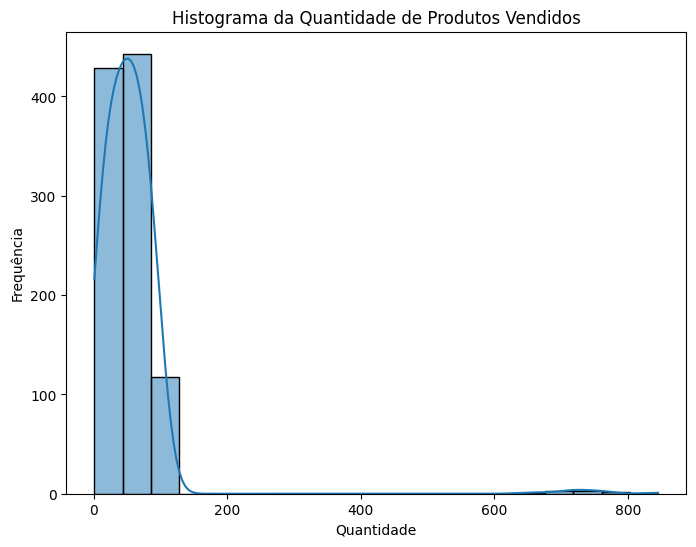

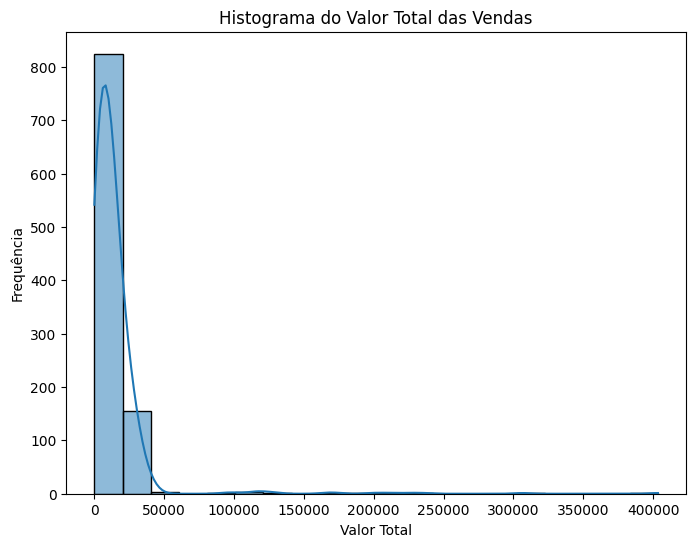

In [14]:
# Histograma para Quantidade
plt.figure(figsize=(8, 6))
sns.histplot(dataset['Quantidade'], bins=20, kde=True)
plt.title('Histograma da Quantidade de Produtos Vendidos')
plt.xlabel('Quantidade')
plt.ylabel('Frequência')
plt.show()

# Histograma para Valor_Total
plt.figure(figsize=(8, 6))
sns.histplot(dataset['Valor_Total'], bins=20, kde=True)
plt.title('Histograma do Valor Total das Vendas')
plt.xlabel('Valor Total')
plt.ylabel('Frequência')
plt.show()

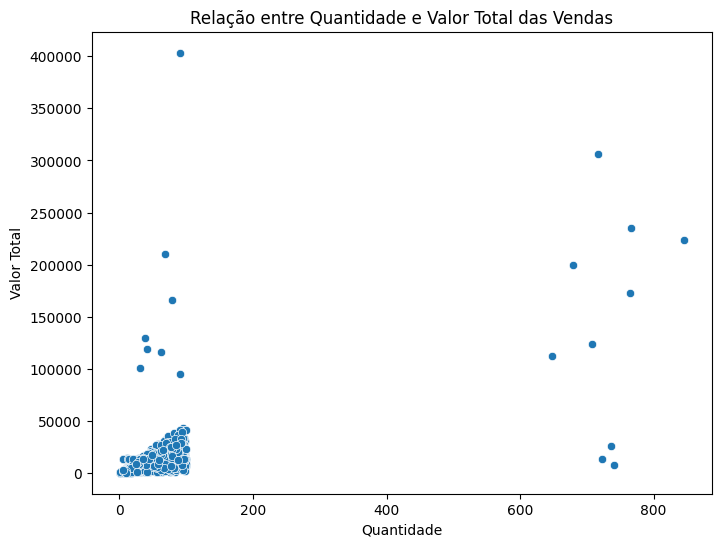

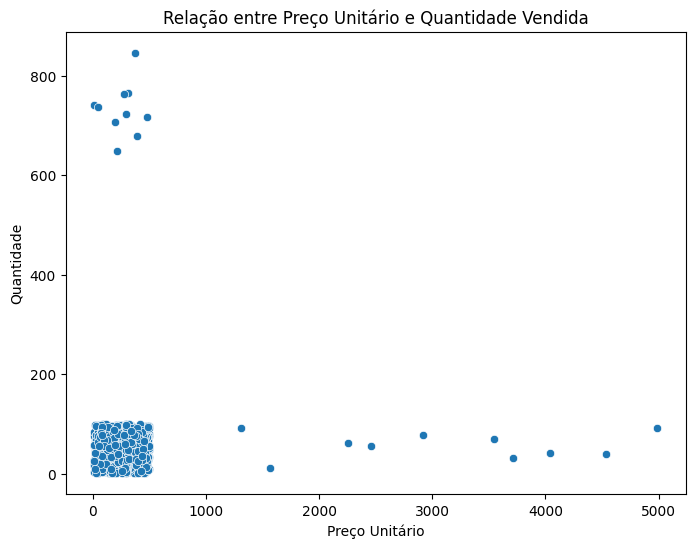

In [15]:
# Gráfico de dispersão: Quantidade vs Valor Total
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Quantidade', y='Valor_Total', data=dataset)
plt.title('Relação entre Quantidade e Valor Total das Vendas')
plt.xlabel('Quantidade')
plt.ylabel('Valor Total')
plt.show()

# Gráfico de dispersão: Preco_Unitario vs Quantidade
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Preco_Unitario', y='Quantidade', data=dataset)
plt.title('Relação entre Preço Unitário e Quantidade Vendida')
plt.xlabel('Preço Unitário')
plt.ylabel('Quantidade')
plt.show()

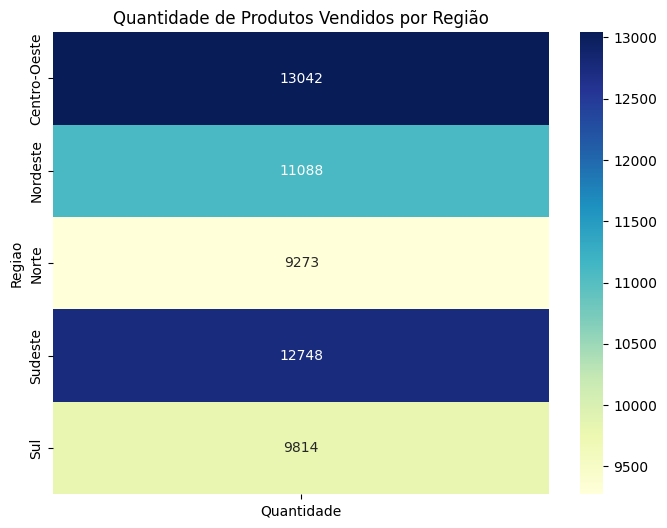

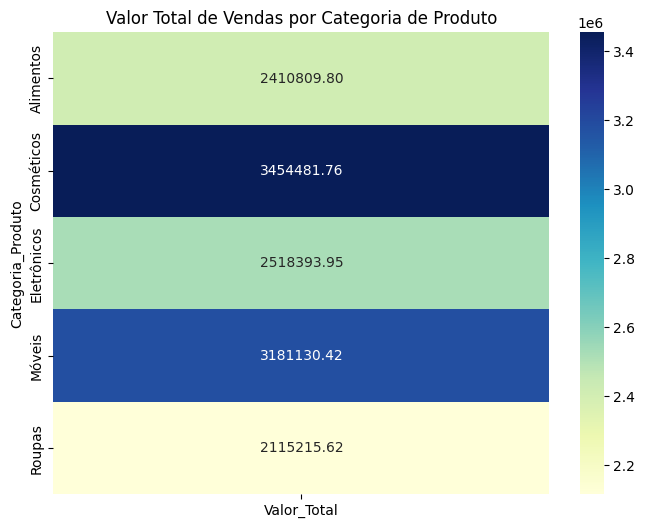

In [16]:
# Gráfico de calor da quantidade de produtos vendidos por região
quantidade_por_regiao = pd.pivot_table(dataset, values='Quantidade', index='Regiao', aggfunc='sum')
plt.figure(figsize=(8, 6))
sns.heatmap(quantidade_por_regiao, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Quantidade de Produtos Vendidos por Região')
plt.show()

# Gráfico de calor do valor total de vendas por categoria de produto
valor_total_por_categoria = pd.pivot_table(dataset, values='Valor_Total', index='Categoria_Produto', aggfunc='sum')
plt.figure(figsize=(8, 6))
sns.heatmap(valor_total_por_categoria, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Valor Total de Vendas por Categoria de Produto')
plt.show()

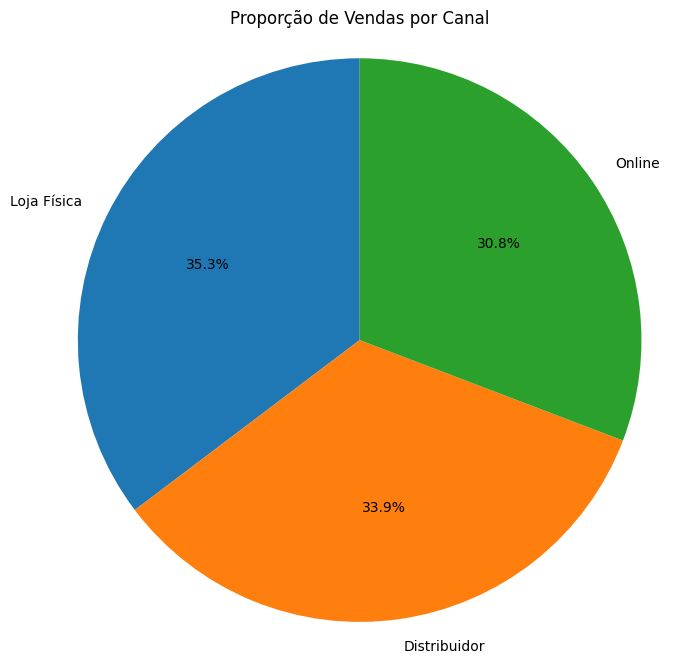

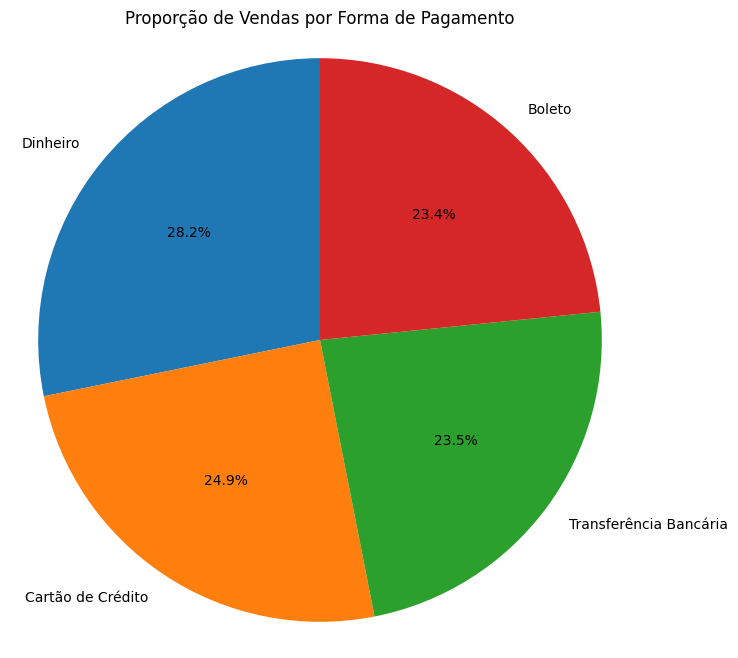

In [17]:
# Gráfico setorial para "Canal_Venda"
canal_venda_counts = dataset['Canal_Venda'].value_counts()
labels = canal_venda_counts.index
sizes = canal_venda_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja um círculo
plt.title('Proporção de Vendas por Canal')
plt.show()

# Gráfico setorial para "Forma_Pagamento"
forma_pagamento_counts = dataset['Forma_Pagamento'].value_counts()
labels = forma_pagamento_counts.index
sizes = forma_pagamento_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja um círculo
plt.title('Proporção de Vendas por Forma de Pagamento')
plt.show()

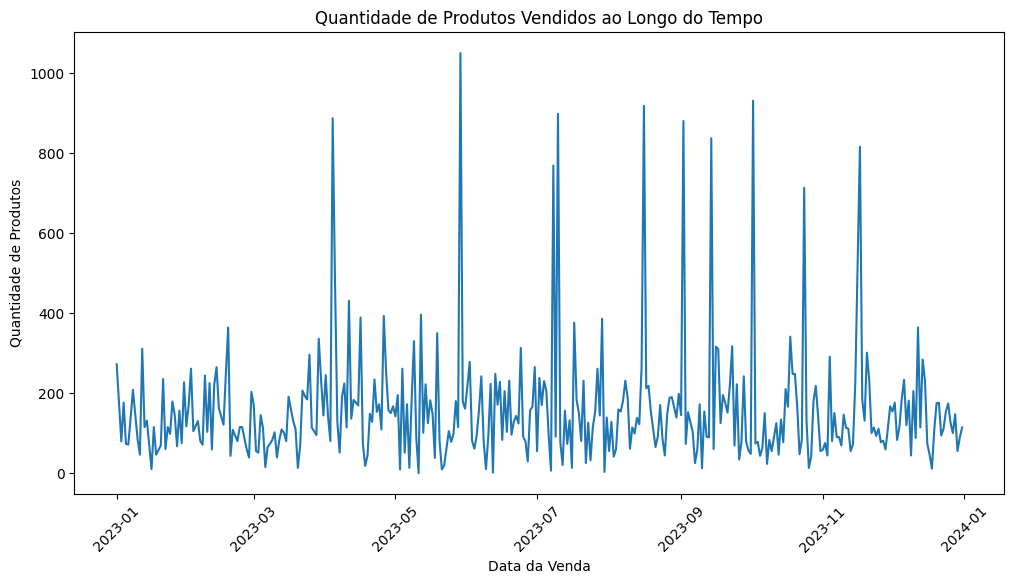

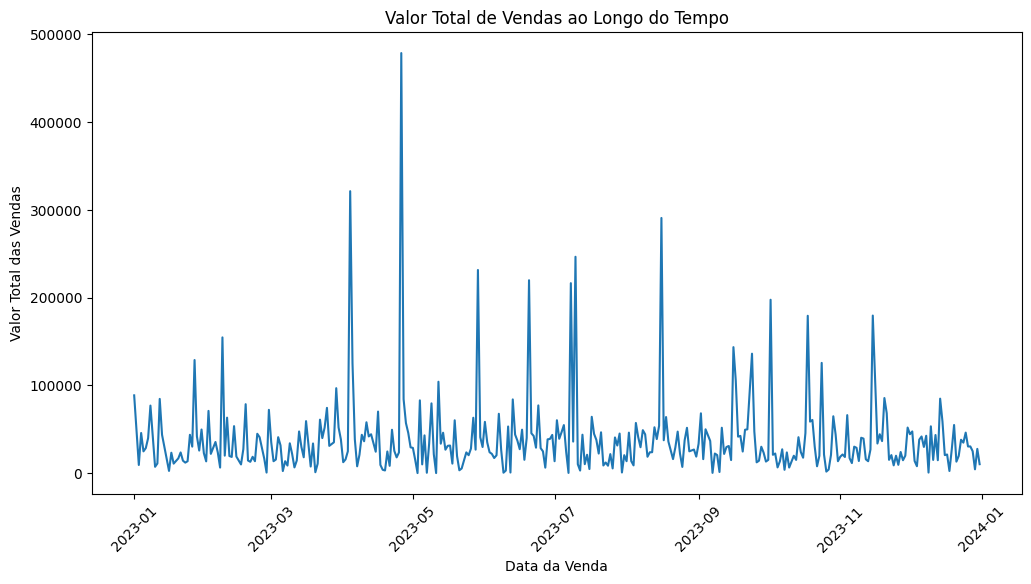

In [18]:
# Gráfico de linha: Quantidade de produtos vendidos ao longo do tempo (se a data estiver disponível)
if 'Data_Venda' in dataset.columns:
  dataset['Data_Venda'] = pd.to_datetime(dataset['Data_Venda'])
  quantidade_por_data = dataset.groupby('Data_Venda')['Quantidade'].sum()
  plt.figure(figsize=(12, 6))
  plt.plot(quantidade_por_data.index, quantidade_por_data.values)
  plt.title('Quantidade de Produtos Vendidos ao Longo do Tempo')
  plt.xlabel('Data da Venda')
  plt.ylabel('Quantidade de Produtos')
  plt.xticks(rotation=45)
  plt.show()

# Gráfico de linha: Valor total de vendas ao longo do tempo (se a data estiver disponível)
if 'Data_Venda' in dataset.columns:
  valor_total_por_data = dataset.groupby('Data_Venda')['Valor_Total'].sum()
  plt.figure(figsize=(12, 6))
  plt.plot(valor_total_por_data.index, valor_total_por_data.values)
  plt.title('Valor Total de Vendas ao Longo do Tempo')
  plt.xlabel('Data da Venda')
  plt.ylabel('Valor Total das Vendas')
  plt.xticks(rotation=45)
  plt.show()

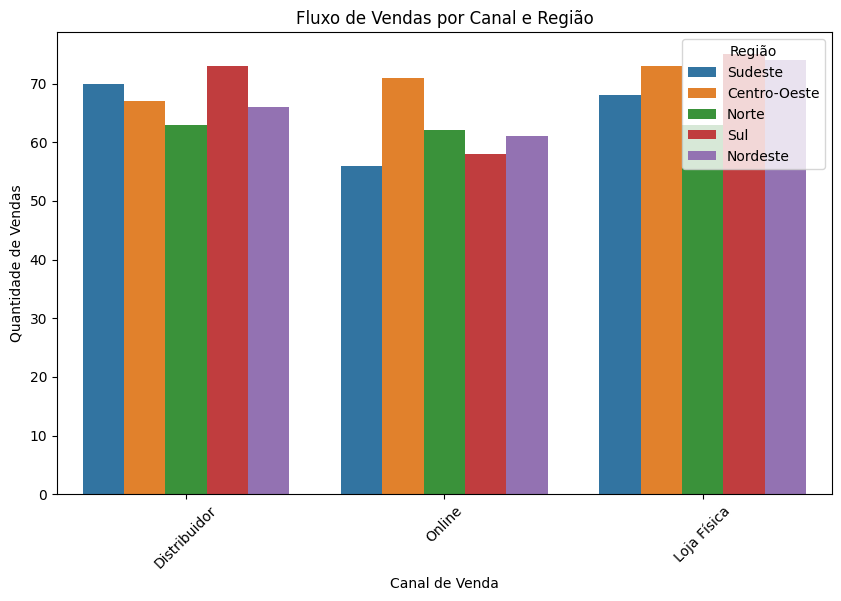

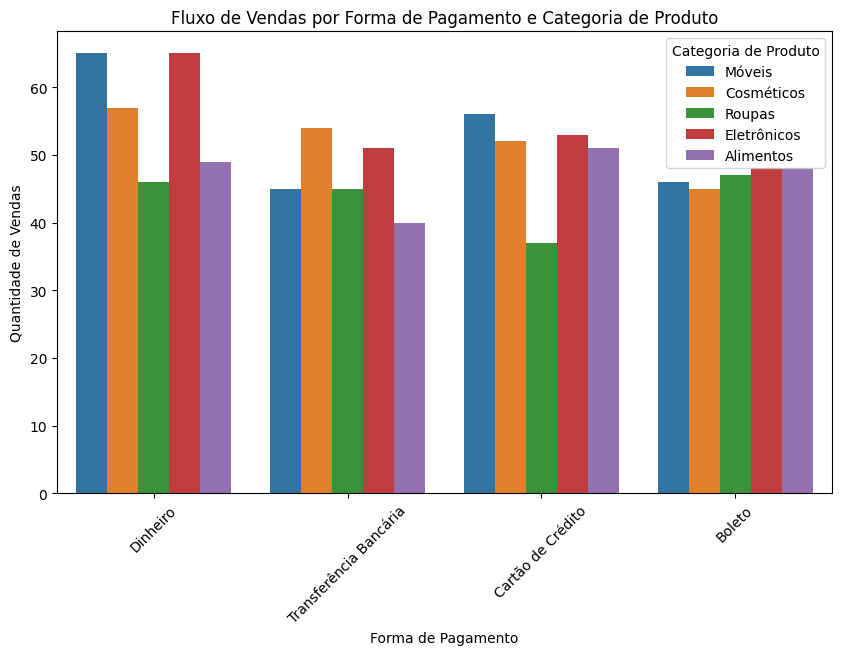

In [19]:
# Gráfico de barras para "Canal_Venda" e "Regiao"
plt.figure(figsize=(10, 6))
sns.countplot(x='Canal_Venda', hue='Regiao', data=dataset)
plt.title('Fluxo de Vendas por Canal e Região')
plt.xlabel('Canal de Venda')
plt.ylabel('Quantidade de Vendas')
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.show()

# Gráfico de barras para "Forma_Pagamento" e "Categoria_Produto"
plt.figure(figsize=(10, 6))
sns.countplot(x='Forma_Pagamento', hue='Categoria_Produto', data=dataset)
plt.title('Fluxo de Vendas por Forma de Pagamento e Categoria de Produto')
plt.xlabel('Forma de Pagamento')
plt.ylabel('Quantidade de Vendas')
plt.xticks(rotation=45)
plt.legend(title='Categoria de Produto')
plt.show()

#### Interpretação do Box Plot

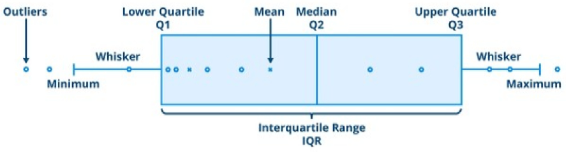

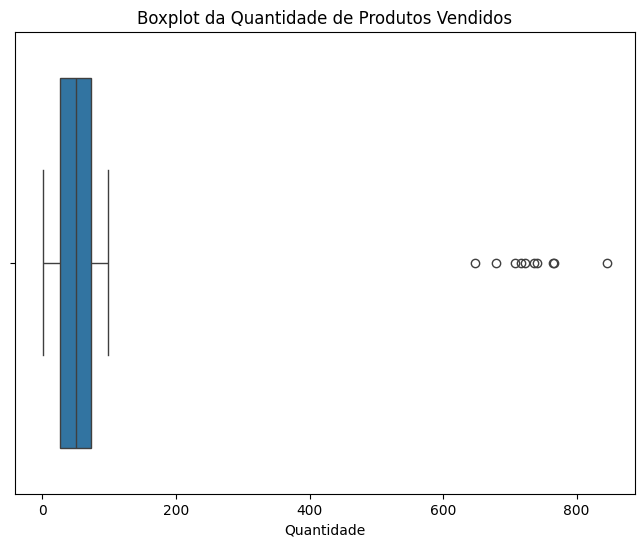

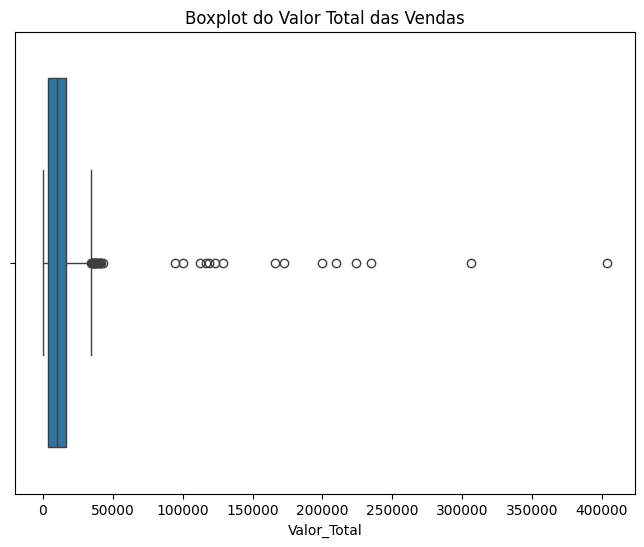

In [20]:
# Boxplot para 'Quantidade'
plt.figure(figsize=(8, 6))
sns.boxplot(x=dataset['Quantidade'])
plt.title('Boxplot da Quantidade de Produtos Vendidos')
plt.show()

# Boxplot para 'Valor_Total'
plt.figure(figsize=(8, 6))
sns.boxplot(x=dataset['Valor_Total'])
plt.title('Boxplot do Valor Total das Vendas')
plt.show()

## Etapa 6: Identificação dos Outliers

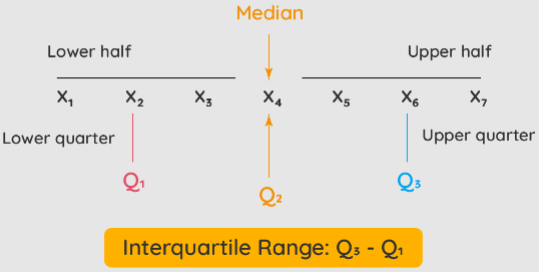

Para calcular o percentual de contaminação de outliers em um dataset, se pode usar o método InterQuartile Range (IQR) que serve para identificar os valores atípicos em cada coluna numérica. O IQR define outliers como valores que estão:

Abaixo de Q1 - 1.5 x IQR

ou

Acima de Q3 + 1.5 x IQR

In [21]:
# Selecionar apenas colunas numéricas
numeric_cols = dataset.select_dtypes(include='number')

# Inicializar contador de outliers
outlier_counts = 0
total_values = numeric_cols.size

# Detectar outliers usando o método IQR para cada coluna numérica
for col in numeric_cols.columns:
    Q1 = numeric_cols[col].quantile(0.25)
    Q3 = numeric_cols[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar outliers
    col_outliers = numeric_cols[(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)][col].count()
    outlier_counts += col_outliers
    print(f"Coluna '{col}' - Outliers: {col_outliers}")

# Calcular o percentual de contaminação de outliers no dataset
outlier = (outlier_counts / total_values)
print("")
print(f"Percentual de contaminação de outliers no dataset: {outlier*100:.2f}%")
print(f"Valor de contaminação de outliers no dataset: {outlier:.4f}")

Coluna 'ID_Venda' - Outliers: 0
Coluna 'ID_Produto' - Outliers: 0
Coluna 'Quantidade' - Outliers: 10
Coluna 'Preco_Unitario' - Outliers: 10
Coluna 'ID_Cliente' - Outliers: 0
Coluna 'Valor_Total' - Outliers: 32
Coluna 'Desconto' - Outliers: 0
Coluna 'Frete' - Outliers: 0

Percentual de contaminação de outliers no dataset: 0.65%
Valor de contaminação de outliers no dataset: 0.0065


### Exibição do Boxplot


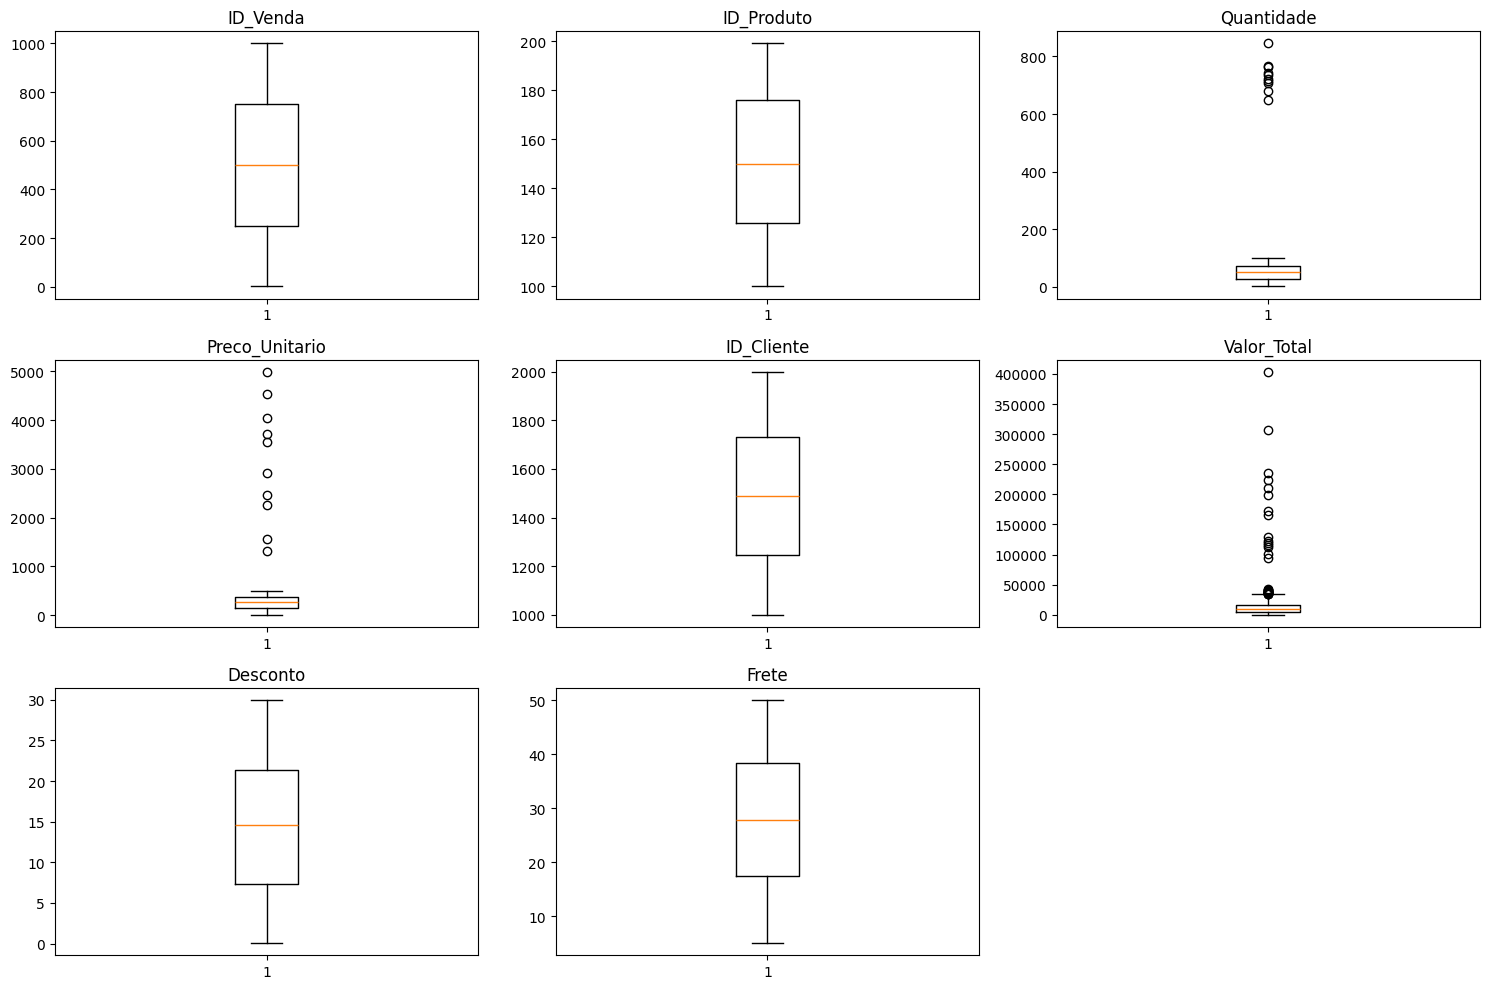

In [24]:
# Criar boxplot para cada coluna numérica para visualizar outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(dataset.select_dtypes(include='number').columns):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(dataset[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Visualização da distribuição dos dados outliers e inliers

Como o Isolation Forest Funciona

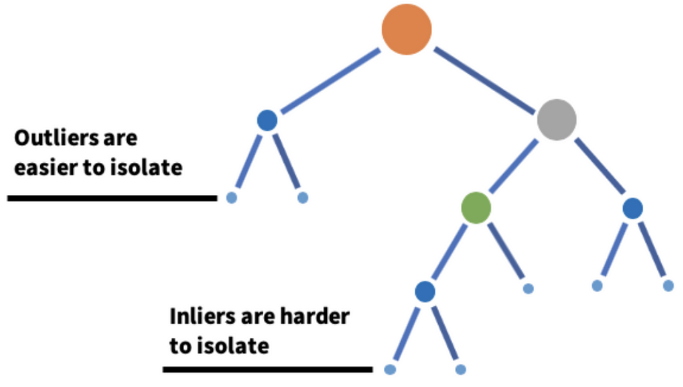

O Isolation Forest é um algoritmo de detecção de anomalias que funciona isolando observações "estranhas" ou "diferentes" dos dados normais. Em vez de modelar as características dos dados normais, o Isolation Forest identifica anomalias de maneira direta, isolando os pontos que estão "distantes" dos outros. É baseado na ideia de que pontos de anomalia devem ser mais fáceis de isolar que os pontos normais.

Construção de Árvores Aleatórias:

O algoritmo começa criando uma floresta de árvores de isolamento. Cada árvore é construída de forma aleatória, e cada divisão (ou split) da árvore separa os dados em diferentes segmentos. A cada divisão, um recurso (feature) é escolhido aleatoriamente, e o ponto de divisão dentro desse recurso também é escolhido de forma aleatória entre o valor mínimo e máximo da amostra. Isolamento das Observações:

O processo de divisão continua até que todas as observações estejam isoladas em nós folhas ou até que a profundidade máxima da árvore seja atingida. Como as anomalias geralmente estão "distantes" do restante dos dados, elas tendem a ser isoladas rapidamente nas árvores. Em outras palavras, as anomalias precisam de menos divisões para serem isoladas.

Cálculo do Score de Anomalia:

Cada ponto recebe um "score de anomalia" com base no número médio de divisões (profundidade média) necessárias para isolá-lo. Quanto menos divisões forem necessárias para isolar um ponto, maior será a probabilidade de ele ser uma anomalia. O score é calculado em uma escala de 0 a 1. Valores próximos de 1 indicam anomalias prováveis, enquanto valores próximos de 0 indicam observações normais. Interpretação do Score:

Com base nos scores de anomalia, é possível definir um limiar. Observações com scores acima do limiar são classificadas como anomalias, enquanto as demais são consideradas normais.

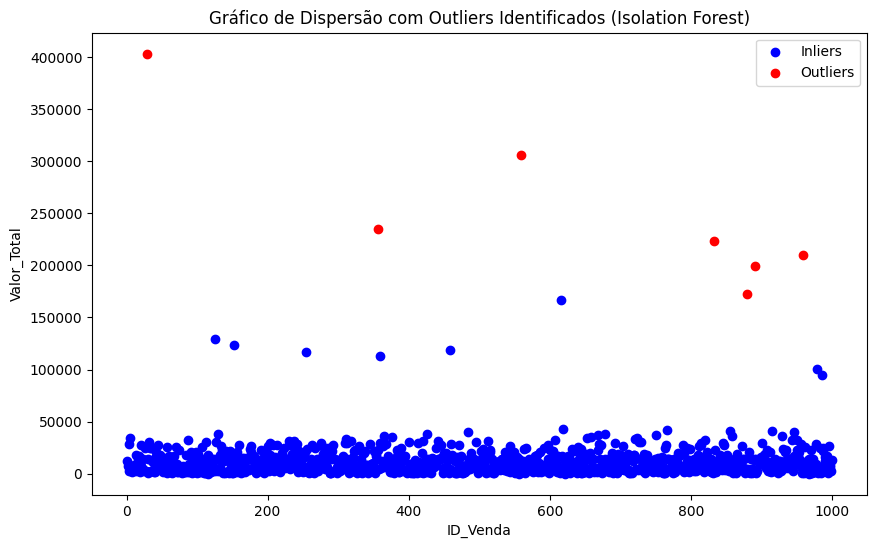

In [25]:
# Criar um modelo IsolationForest com o percentual de contaminação definido
model = IsolationForest(contamination=outlier, random_state=42)

# Ajustar o modelo aos dados das colunas ID_Venda e Valor_Total
X = dataset[['ID_Venda', 'Valor_Total']]
model.fit(X)

# Prever se os dados são outliers ou inliers
y_pred = model.predict(X)

# Criar um DataFrame com as previsões
dataset['Outlier'] = y_pred

# Plotar o gráfico de dispersão com os outliers e inliers
plt.figure(figsize=(10, 6))
plt.scatter(
    dataset.loc[dataset['Outlier'] == 1, 'ID_Venda'],
    dataset.loc[dataset['Outlier'] == 1, 'Valor_Total'],
    c='blue',
    label='Inliers',
)
plt.scatter(
    dataset.loc[dataset['Outlier'] == -1, 'ID_Venda'],
    dataset.loc[dataset['Outlier'] == -1, 'Valor_Total'],
    c='red',
    label='Outliers',
)
plt.xlabel('ID_Venda')
plt.ylabel('Valor_Total')
plt.title('Gráfico de Dispersão com Outliers Identificados (Isolation Forest)')
plt.legend()
plt.show()

Como o One-Class SVM funciona

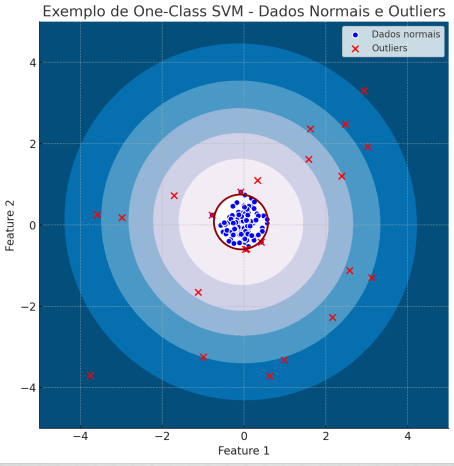

O One-Class SVM aprende os limites de um conjunto de dados normal e tenta identificar pontos que estejam fora desses limites. Em vez de classificar dados em duas ou mais classes, ele separa os dados normais do "espaço vazio" onde os outliers provavelmente se encontram.

O algoritmo projeta os dados para um espaço de alta dimensionalidade usando um kernel (como no SVM tradicional). Em seguida, encontra uma hiperplano ou fronteira que englobe a maioria dos dados normais, deixando os pontos fora dela como anomalias. O objetivo é maximizar a margem ao redor dos dados normais enquanto minimiza os erros de inclusão, isto é, dados normais erroneamente considerados outliers.

O modelo é treinado apenas com dados da classe normal. Aprendendo sobre uma região compacta que abrange a maior parte dos dados. Assim, quando novos dados são apresentados, o modelo verifica se eles estão dentro ou fora da região aprendida.

Os Hiperparâmetros importantes são: ν (nu), que controla a fração máxima de outliers permitidos no conjunto de treinamento e afeta a complexidade do modelo; Kernel, que define a função usada para projetar os dados para o espaço de alta dimensionalidade, podendo ser linear ou RBF (Radial Basis Function, para dados não lineares).

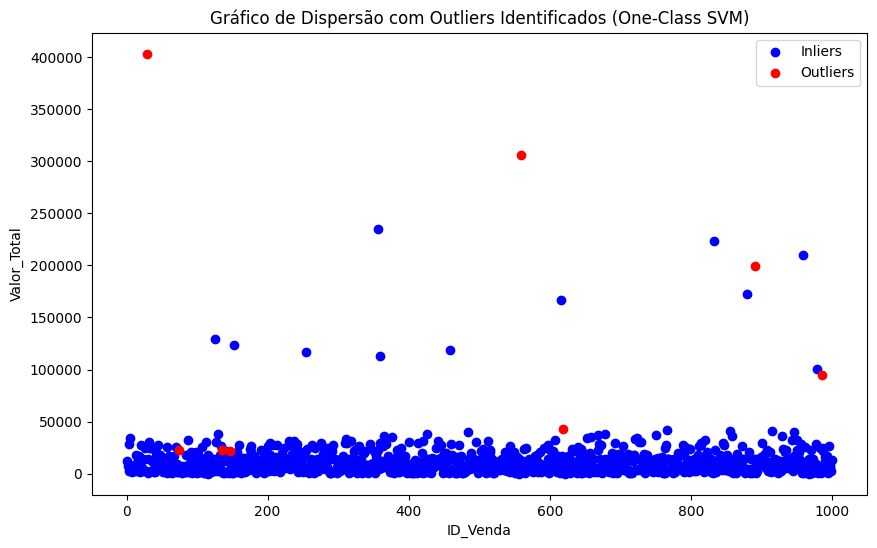

In [26]:
# Criar um modelo One-Class SVM com o percentual de contaminação definido
model = OneClassSVM(nu=outlier, kernel='rbf', gamma='scale')

# Ajustar o modelo aos dados das colunas ID_Venda e Valor_Total
X = dataset[['ID_Venda', 'Valor_Total']]
model.fit(X)

# Prever se os dados são outliers ou inliers
y_pred = model.predict(X)

# Criar um DataFrame com as previsões
dataset['Outlier'] = y_pred

# Plotar o gráfico de dispersão com os outliers e inliers
plt.figure(figsize=(10, 6))
plt.scatter(
    dataset.loc[dataset['Outlier'] == 1, 'ID_Venda'],
    dataset.loc[dataset['Outlier'] == 1, 'Valor_Total'],
    c='blue',
    label='Inliers',
)
plt.scatter(
    dataset.loc[dataset['Outlier'] == -1, 'ID_Venda'],
    dataset.loc[dataset['Outlier'] == -1, 'Valor_Total'],
    c='red',
    label='Outliers',
)
plt.xlabel('ID_Venda')
plt.ylabel('Valor_Total')
plt.title('Gráfico de Dispersão com Outliers Identificados (One-Class SVM)')
plt.legend()
plt.show()

Como funciona o Estimador de Covariância

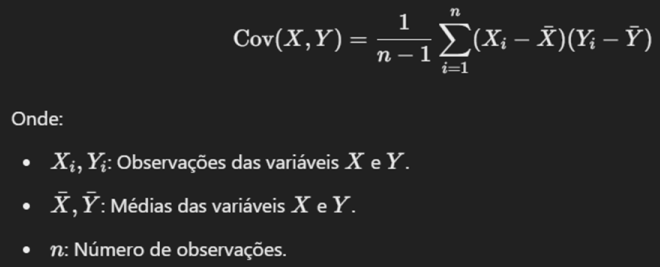

O estimador de covariância é uma ferramenta estatística utilizada para calcular e entender as relações entre variáveis em um conjunto de dados. Ele mede como duas ou mais variáveis variam juntas (ou seja, se aumentam ou diminuem ao mesmo tempo). É essencial em muitas áreas, incluindo aprendizado de máquina, finanças e análise de dados, especialmente na modelagem de distribuições multivariadas.

A covariância indica o grau de relacionamento linear entre duas variáveis:

•	Se positiva, as variáveis tendem a aumentar juntas.

•	Se negativa, quando uma aumenta, a outra tende a diminuir.

•	Se próxima de zero, não há relação linear significativa.

Estimadores comuns de covariância:

1. Estimador máximo de verossimilhança (MLE): usado com dados que seguem uma distribuição normal e sensível a outliers.

2. Estimadores robustos: ajustam-se melhor em presença de outliers ou dados não normalmente distribuídos. Exemplos: Minimum Covariance Determinant (MCD), encontra a menor elipse que engloba a maior parte dos dados; Shrinkage, Combina o estimador tradicional com uma matriz fixa (como identidade), reduzindo a influência de pequenos conjuntos de dados; Estimadores baseados em penalização, são usados em alta dimensionalidade, onde o número de variáveis é maior que o número de observações.

Aplicações do estimador de covariância: Redução de dimensionalidade, usado em técnicas como PCA (Análise de Componentes Principais); Análise de portfólios financeiros, determina como ativos financeiros se correlacionam para criar diversificação; Detecção de outliers, modelos como o Elliptic Envelope utilizam a matriz de covariância para identificar anomalias; e, Modelagem probabilística, essencial para definir distribuições como a multivariada normal.

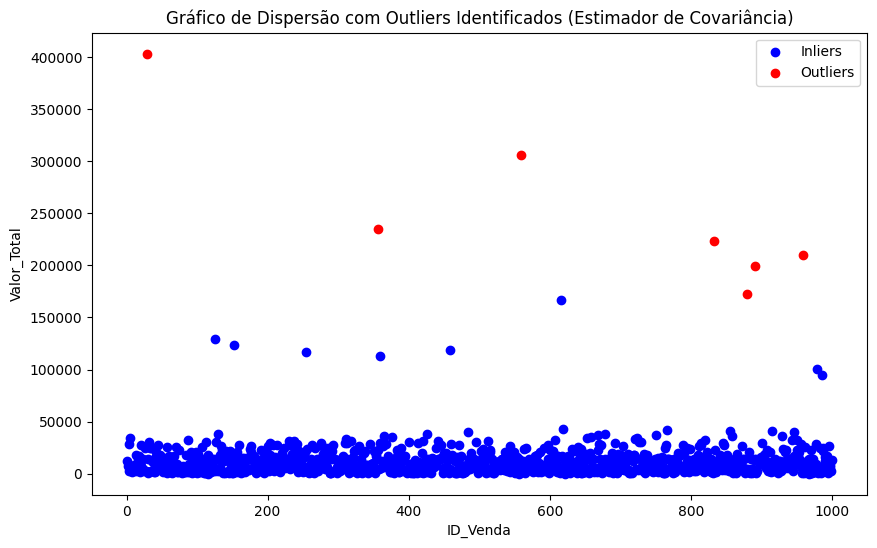

In [27]:
# Criar um modelo EllipticEnvelope com o percentual de contaminação definido
model = EllipticEnvelope(contamination=outlier)

# Ajustar o modelo aos dados das colunas ID_Venda e Valor_Total
X = dataset[['ID_Venda', 'Valor_Total']]
model.fit(X)

# Prever se os dados são outliers ou inliers
y_pred = model.predict(X)

# Criar um DataFrame com as previsões
dataset['Outlier'] = y_pred

# Plotar o gráfico de dispersão com os outliers e inliers
plt.figure(figsize=(10, 6))
plt.scatter(
    dataset.loc[dataset['Outlier'] == 1, 'ID_Venda'],
    dataset.loc[dataset['Outlier'] == 1, 'Valor_Total'],
    c='blue',
    label='Inliers',
)
plt.scatter(
    dataset.loc[dataset['Outlier'] == -1, 'ID_Venda'],
    dataset.loc[dataset['Outlier'] == -1, 'Valor_Total'],
    c='red',
    label='Outliers',
)
plt.xlabel('ID_Venda')
plt.ylabel('Valor_Total')
plt.title('Gráfico de Dispersão com Outliers Identificados (Estimador de Covariância)')
plt.legend()
plt.show()

### Separação dos Outliers dos Inliers

In [28]:
# Selecionar apenas colunas numéricas para a detecção de outliers
numeric_data = dataset.select_dtypes(include='number')

# Configurar e aplicar o Isolation Forest com contaminação
iso_forest = IsolationForest(contamination=outlier, random_state=42)
outlier_labels = iso_forest.fit_predict(numeric_data)

# Adicionar os rótulos de outliers ao dataset
dataset['is_outlier'] = outlier_labels

# Filtrar apenas os outliers (rótulo -1)
outliers = dataset[dataset['is_outlier'] == -1]

# Exibir os dados que são outliers
print("Dados identificados como outliers:")
print(outliers.to_string())

# Exibir a quantidade de outliers detectados
outlier_count = len(outliers)
print(f"\nTotal de outliers: {outlier_count}")

Dados identificados como outliers:
     ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Outlier  is_outlier
28         29 2023-04-26         108        91.0         4989.41        1204    403467.56   Loja Física                Dinheiro     11.14  10.89  Centro-Oeste            Móveis       -1          -1
356       357 2023-08-16         180       766.0          307.57        1211    234712.67  Distribuidor       Cartão de Crédito      0.38   9.32       Sudeste        Cosméticos       -1          -1
558       559 2023-04-04         177       716.0          477.17        1088    306474.28  Distribuidor       Cartão de Crédito     10.31  45.06       Sudeste        Cosméticos       -1          -1
832       833 2023-07-10         113       845.0          373.53        1448    223698.16   Loja Física                Dinheiro     29.13   9.16       Sudeste            Móv

In [29]:
# Remover os outliers
try:
    dataset = dataset[dataset['is_outlier'] == 1].drop(columns=['is_outlier'])
except Exception as e:
    print(f"Ocorreu um erro: {e}")

In [30]:
# Remover a coluna 'Outlier' do dataset
if 'Outlier' in dataset.columns:
  dataset = dataset.drop('Outlier', axis=1)

# Remover a coluna 'is_outlier' do dataset
if 'is_outlier' in dataset.columns:
  dataset = dataset.drop('is_outlier', axis=1)

In [31]:
# Exibir o dataset sem os outliers
print("Dataset sem os outliers:")
print(dataset.head().to_string())

# Exibir informações gerais do dataset
print("\nInformações Gerais do Dataset:")
print(dataset.info())

Dataset sem os outliers:
   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Onlin

## Etapa 7: Preprocessamento de Dados (Parametrização, Codificação e Normalização)

### Rules

In [32]:
# Definir a primeira coluna como meta, a última como target e as demais como features
meta = dataset.columns[0]
target = dataset.columns[-1]
features = dataset.columns[1:-1]

print(f"Meta: {meta}")
print(f"Target: {target}")
print(f"Features: {features}")

Meta: ID_Venda
Target: Categoria_Produto
Features: Index(['Data_Venda', 'ID_Produto', 'Quantidade', 'Preco_Unitario',
       'ID_Cliente', 'Valor_Total', 'Canal_Venda', 'Forma_Pagamento',
       'Desconto', 'Frete', 'Regiao'],
      dtype='object')


### Encoding

In [ ]:
# Técnicas de Encoding
# Label Encoding: Simples e direto, útil para variáveis ordinais.
# One-Hot Encoding: Ideal para variáveis nominais com poucas categorias.
# Binary Encoding: Reduz o número de colunas para variáveis com muitas categorias.
# Target Encoding: Útil para problemas supervisionados, especialmente com muitas categorias.
# Frequency Encoding: Captura a frequência das categorias.
# Ordinal Encoding: Para variáveis categóricas com ordem.
# Hash Encoding: Útil para um número muito grande de categorias, porém pode introduzir colisões.

In [33]:
# Label Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Criar um objeto LabelEncoder
le = LabelEncoder()

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Aplicar Label Encoding na coluna atual
  datasetx[column] = le.fit_transform(datasetx[column])

# Exibir o datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Label Encoding):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Online                  Boleto

In [34]:
# One-Hot Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Aplicar One-Hot Encoding na coluna atual
  datasetx = pd.get_dummies(datasetx, columns=[column], prefix=[column])

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (One-Hot Encoding):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Online                  Boleto

In [35]:
# Binary Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Criar um dicionário para mapear categorias para valores binários
  unique_categories = datasetx[column].unique()
  category_mapping = {category: bin(i)[2:].zfill(len(bin(len(unique_categories) - 1)[2:])) for i, category in enumerate(unique_categories)}

  # Aplicar Binary Encoding na coluna atual
  datasetx[column] = datasetx[column].map(category_mapping)

  # Separar as colunas binárias criadas
  for bit_index in range(len(bin(len(unique_categories) - 1)[2:])):
    new_column_name = f"{column}_bit_{bit_index + 1}"
    datasetx[new_column_name] = datasetx[column].str[bit_index].astype(int)

  # Remover a coluna original com a representação binária
  datasetx = datasetx.drop(columns=[column])

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Binary Encoding):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Online                  Boleto

In [36]:
# Frequency Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Calcular a frequência de cada categoria na coluna atual
  frequency_encoding = datasetx.groupby(column)[column].transform('count') / len(datasetx)

  # Substituir as categorias pelos valores codificados (frequência)
  datasetx[column] = frequency_encoding

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Frequency Encoding):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Online                  Boleto

In [37]:
# Hash Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Aplicar Hash Encoding na coluna atual
  datasetx[column] = datasetx[column].apply(hash)

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Hash Encoding):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Online                  Boleto

In [38]:
# Ordinal Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Criar um dicionário para mapear categorias para valores ordinais
  unique_categories = datasetx[column].unique()
  category_mapping = {category: i for i, category in enumerate(unique_categories)}

  # Aplicar Ordinal Encoding na coluna atual
  datasetx[column] = datasetx[column].map(category_mapping)

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Ordinal Encoding):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos
3         4 2023-07-12         193        21.0          189.50        1576      3012.53   Loja Física                Dinheiro     25.10  31.88       Sudeste            Roupas
4         5 2023-11-20         111        92.0          463.81        1161     34424.12        Online                  Boleto

In [39]:
# Label encoding
for column in dataset.select_dtypes(include=['object']):
  # Criar um objeto LabelEncoder
  le = LabelEncoder()

  # Aplicar Label Encoding na coluna original
  dataset[column + '_encoded'] = le.fit_transform(dataset[column])

# Exibir o dataset com os novos campos criados com base no label encoding
print("Dataset com novos campos com Label Encoding:")
print(dataset.head().to_string())

Dataset com novos campos com Label Encoding:
   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste       

### Normalizing

In [ ]:
# Técnicas de normalização
# Z-Score Normalization: Centraliza dados em torno da média 0 e desvio padrão 1.
# Max Abs Scaling: Escala pelo valor absoluto máximo, útil para dados com média próxima de 0.
# L1/L2 Normalization: Usa normas para normalizar os dados em relação à soma absoluta ou quadrática.
# Robust Scaling: Usa a mediana e IQR, ideal para dados com outliers.
# Log Transformation: Reduz a escala de valores grandes e ajusta distribuições distorcidas.
# Power Transformations: Ajusta distribuições para se aproximarem de uma normal.
# Min-Max Scaling: Escala os dados entre um intervalo específico (0-1, geralmente).

In [40]:
# Power Transformations
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Selecionar apenas colunas numéricas para a normalização
numeric_cols = datasetx.select_dtypes(include=['number']).columns

# Criar um objeto PowerTransformer
pt = PowerTransformer()

# Aplicar Power Transformations às colunas numéricas
datasetx[numeric_cols] = pt.fit_transform(datasetx[numeric_cols])

# Exibir o dataset normalizado
print("Dataset normalizado com Power Transformations:")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [41]:
# Log Transformation
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas numéricas do datasetn
for column in datasetx.select_dtypes(include=['number']):
  # Aplicar Log Transformation na coluna atual, tratando possíveis valores negativos
  datasetx[column] = np.log1p(datasetx[column])

# Exibir o datasetn com as colunas numéricas normalizadas
print("Dataset com colunas numéricas normalizadas (Log Transformation):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [42]:
# Robust Scaling
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Selecionar as colunas numéricas para normalização
numerical_cols = datasetx.select_dtypes(include=np.number).columns

# Criar um objeto RobustScaler
scaler = RobustScaler()

# Aplicar Robust Scaling às colunas numéricas
datasetx[numerical_cols] = scaler.fit_transform(datasetx[numerical_cols])

# Exibir o datasetn com as features normalizadas
print("Datasetn com features normalizadas (Robust Scaling):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [43]:
# L1 Normalization
datasetx = dataset.copy()
print(datasetx.head().to_string())

# L1 Normalization
for column in datasetx.select_dtypes(include=['number']):
    datasetx[column] = datasetx[column] / np.linalg.norm(datasetx[column], ord=1)

print("Dataset com features normalizadas (L1):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [44]:
# Max Abs Scaling
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Normalizar as features usando Max Abs Scaling
for column in datasetx.columns:
  if pd.api.types.is_numeric_dtype(datasetx[column]):
    # Aplicar Max Abs Scaling à coluna atual
    datasetx[column] = datasetx[column] / datasetx[column].abs().max()

# Exibir o dataset normalizado
print("Dataset normalizado com Max Abs Scaling:")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [45]:
# Z-Score Normalization
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Criar um objeto StandardScaler
scaler = StandardScaler()

# Iterar pelas colunas numéricas do datasetx
for column in datasetx.select_dtypes(include=['number']):
  # Aplicar Z-Score Normalization na coluna atual
  datasetx[column] = scaler.fit_transform(datasetx[[column]])

# Exibir o datasetx com as colunas numéricas normalizadas
print("Dataset com colunas numéricas normalizadas (Z-Score Normalization):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [46]:
# MinMaxScaler
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Criar um objeto MinMaxScaler
scaler = MinMaxScaler()

# Iterar pelas colunas numéricas do datasetx
datasetx[numerical_cols] = scaler.fit_transform(datasetx[numerical_cols])

# Exibir o datasetx normalizado
print("Datasetn com colunas numéricas normalizadas (MinMaxScaler):")
print(datasetx.head().to_string())

   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3
1         2 2023-02-17         186        44.0          184.88        1545      7735.18        Online  Transferência Bancária      5.12  16.96  Centro-Oeste        Cosméticos                    2                        3               0                          1
2         3 2023-04-28         157        68.0          467.58        1468     28034.97   Loja Física       Cartão de Crédito     11.96  42.26  Centro-Oeste        Cosméticos                    1             

In [47]:
# MinMaxScaler
scaler = MinMaxScaler()

# Iterar pelas colunas numéricas do datasetx
for column in dataset.select_dtypes(include=['number']):
  # Aplicar MinMaxScaler na coluna atual e criar um novo campo com o sufixo "_minmax"
  dataset[column + '_minmax'] = scaler.fit_transform(dataset[[column]])

# Exibir o datasetx com os novos campos normalizados
print("Dataset com novos campos normalizados com MinMaxScaler:")
print(dataset.head().to_string())

Dataset com novos campos normalizados com MinMaxScaler:
   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded  ID_Venda_minmax  ID_Produto_minmax  Quantidade_minmax  Preco_Unitario_minmax  ID_Cliente_minmax  Valor_Total_minmax  Desconto_minmax  Frete_minmax  Canal_Venda_encoded_minmax  Forma_Pagamento_encoded_minmax  Regiao_encoded_minmax  Categoria_Produto_encoded_minmax
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3         0.000000           0.686869           0.074324               0.062115           0.281281            0.070159         0.941137      0.168037    

## Etapa 8: Redução da Dimensionalidade

Como o PCA funciona

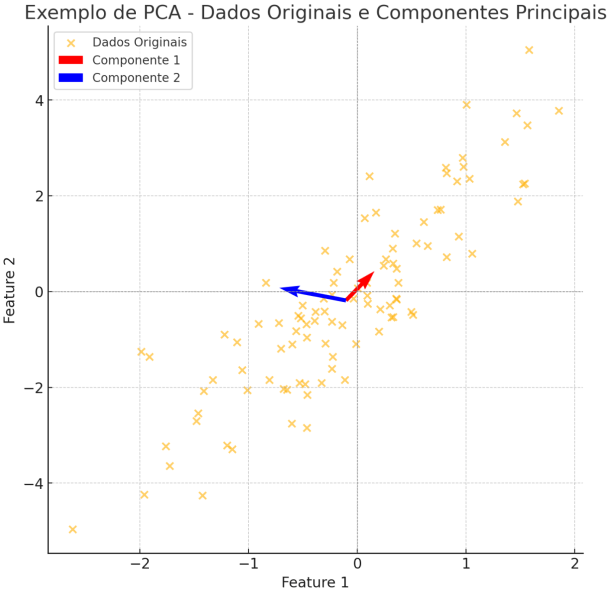

O PCA começa garantindo que todas as variáveis tenham a mesma escala. Normaliza os dados para que cada variável tenha média 0 e desvio padrão 1. O PCA mede como as variáveis se relacionam entre si. Para isso, calcula a matriz de covariância ou, em alguns casos, a matriz de correlação. A matriz de covariância captura a variabilidade conjunta entre as variáveis.

Cálculo dos autovalores e autovetores: Os autovalores (𝜆) representam a variância explicada por cada componente principal. Os autovetores (𝑣) indicam a direção dos componentes principais no espaço de dados. Resolvem a equação característica: (𝐶−𝜆𝐼)𝑣=0. Onde C é a matriz de covariância, λ é o autovalor, I é a matriz identidade e v o autovetor.

Escolha dos componentes principais: Os autovalores são ordenados em ordem decrescente. Os primeiros componentes principais (com maiores autovalores) são selecionados para representar os dados.

Transformação dos dados: Os dados originais são projetados nos novos eixos definidos pelos autovetores escolhidos. Isso reduz a dimensionalidade, preservando o máximo de variância.

In [48]:
# Verificar se as colunas 'pc1' e 'pc2' já existem no dataset
if 'pc1' not in dataset.columns or 'pc2' not in dataset.columns:
  # Selecionar apenas as colunas com sufixo '_minmax'
  minmax_columns = [col for col in dataset.columns if col.endswith('_minmax')]
  dataset_minmax = dataset[minmax_columns]

  # Substituir valores NaN por 0
  dataset_minmax = dataset_minmax.fillna(0)

  # Aplicar PCA com 2 componentes principais
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(dataset_minmax)

  # Criar as colunas 'pc1' e 'pc2' no dataset original com os componentes principais
  dataset['pc1'] = principal_components[:, 0]
  dataset['pc2'] = principal_components[:, 1]
else:
  # Se as colunas 'pc1' e 'pc2' já existem, atualizar os valores com os novos componentes principais
  minmax_columns = [col for col in dataset.columns if col.endswith('_minmax')]
  dataset_minmax = dataset[minmax_columns]

  # Substituir valores NaN por 0
  dataset_minmax = dataset_minmax.fillna(0)

  # Aplicar PCA com 2 componentes principais
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(dataset_minmax)

  # Atualizar os valores das colunas 'pc1' e 'pc2'
  dataset['pc1'] = principal_components[:, 0]
  dataset['pc2'] = principal_components[:, 1]

## Etapa 9: Clusterização

### Técnicas para identificação do hiperparametro K

Como funciona a técnica do silhueta

Para cada ponto i no conjunto de dados:

Cálculo da Coesão (a(i)):

a(i) é a distância média entre o ponto i e todos os outros pontos no mesmo cluster. Representa o quão bem o ponto está associado ao seu cluster.

Cálculo da Separação (b(i)):

b(i) é a distância média entre o ponto i e os pontos do cluster mais próximo (que não inclui i). Representa o quão longe o ponto está do cluster vizinho.

Coeficiente de Silhueta (s(i)):

A silhueta é calculada para cada ponto com a fórmula: s(i) = b(i)−a(i) / max(a(i),b(i))

Onde:

−1≤s(i)≤1

s(i)≈1: Ponto bem agrupado (longe dos outros clusters).

s(i)≈0: Ponto na borda entre dois clusters.

s(i)≈−1: Ponto provavelmente atribuído ao cluster errado.

Média da Silhueta

Para avaliar a qualidade global de um agrupamento, calcula-se a média da silhueta de todos os pontos:

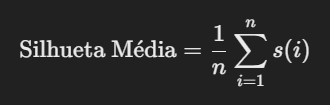

Interpretação dos Resultados

Silhueta próxima de 1: Clusters são bem definidos; Cada ponto está bem dentro do seu cluster e distante de outros clusters.

Silhueta próxima de 0: Pontos estão na borda de clusters. Os clusters podem estar se sobrepondo.

Silhueta negativa: Indica clusters mal formados. Pontos estão mais próximos de clusters vizinhos do que do seu próprio cluster.

Vantagens da Técnica da Silhueta

Simples de interpretar: Fornece um único número para avaliar a qualidade de agrupamentos. Independente do algoritmo: Pode ser usada com qualquer técnica de clustering. Diagnóstico de clusters: Ajuda a identificar pontos mal agrupados.

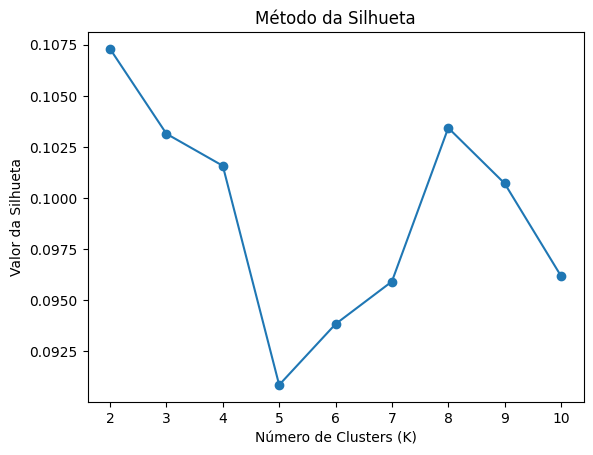

Melhor valor de K (Método da Silhueta): 2


In [49]:
# Selecionar apenas as colunas com o sufixo "_minmax"
df_minmax = dataset[[col for col in dataset.columns if col.endswith('_minmax')]]
df_minmax = df_minmax.dropna()

# Lista para armazenar os valores de silhueta para diferentes valores de K
silhouette_avg = []

# Testar valores de K de 2 a 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_minmax)
    silhouette_avg.append(silhouette_score(df_minmax, cluster_labels))

# Plotar o gráfico da silhueta
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.title('Método da Silhueta')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Valor da Silhueta')
plt.show()

# Encontrar o melhor valor de K (o valor de K que maximiza a silhueta)
best_k = np.argmax(silhouette_avg) + 2

print(f"Melhor valor de K (Método da Silhueta): {best_k}")

Como funciona a técnica do cotovelo

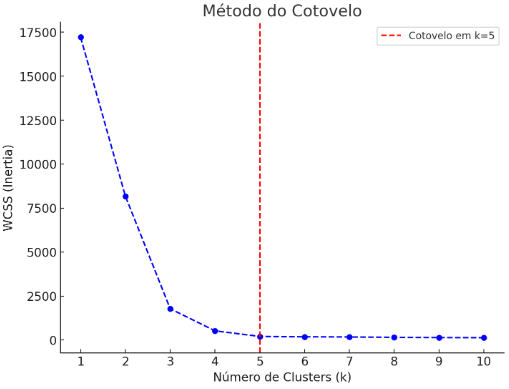

Escolher uma métrica de avaliação: Normalmente, utiliza-se a Soma das Distâncias Quadráticas Dentro dos Clusters (Within-Cluster Sum of Squares - WCSS), que mede a soma das distâncias dos pontos ao centro do cluster.

Executar o algoritmo para diferentes números de clusters k: Calcular o WCSS para diferentes valores de k, geralmente começando de 1 até um valor razoável, como 10 ou 15.

Plotar o gráfico k×WCSS: O eixo x representa o número de clusters k. O eixo y representa o WCSS.

Identificar o "cotovelo": No gráfico, o ponto onde a curva começa a "achatar" é o ponto ideal. Este é o número de clusters onde adicionar mais clusters resulta em uma diminuição marginal da variabilidade explicada. O cotovelo representa o ponto em que a soma das distâncias quadráticas dentro dos clusters diminui de forma insignificante com o aumento de k, indicando que adicionar mais clusters não está melhorando substancialmente a qualidade do agrupamento.

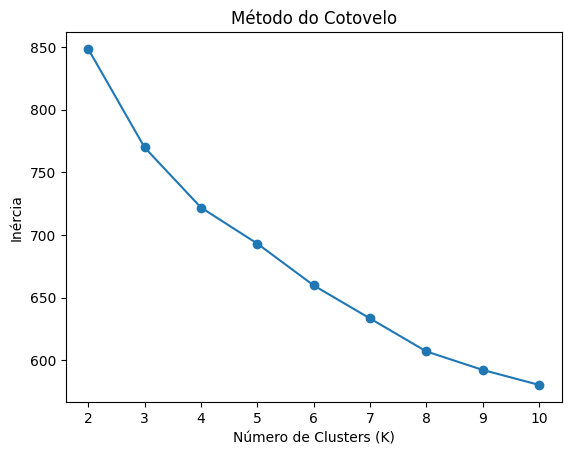

Melhor valor de K (Método do Cotovelo): 2


In [50]:
# Selecionar apenas as colunas com o sufixo "_minmax"
df_minmax = dataset[[col for col in dataset.columns if col.endswith('_minmax')]]

# Lista para armazenar a inércia para diferentes valores de K
inertia = []

# Testar valores de K de 2 a 10
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_minmax)
  inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.show()

# Encontrar o melhor valor de K (o ponto de inflexão no gráfico)
# Pode ser feito visualmente ou usando alguma técnica de detecção de inflexão
# Neste exemplo, vamos usar a visualização para determinar o melhor K
# O melhor K parece ser 3, mas isso depende do gráfico gerado.
best_k = np.argmax(np.diff(inertia) * -1) + 2
print(f"Melhor valor de K (Método do Cotovelo): {best_k}")

### Algoritmo de Clusterização (KMeans)

In [51]:
# Definir os hiperparâmetros do KMeans
kmeans_params = {
    'n_clusters': best_k,  # Número de clusters (obtido pelo método do cotovelo ou silhueta)
    'init': 'k-means++',  # Método de inicialização dos centroides
    'n_init': 100,  # Número de vezes que o algoritmo é executado com diferentes inicializações
    'max_iter': 1000,  # Número máximo de iterações do algoritmo
    'tol': 1e-4,  # Tolerância para a convergência do algoritmo
    'random_state': 42  # Seed para a reprodutibilidade dos resultados
}

In [52]:
# Selecionar apenas as colunas com o sufixo "_minmax" para criar o modelo kmeans
df_minmax = dataset[[col for col in dataset.columns if col.endswith('_minmax')]]
df_minmax = df_minmax.dropna()

# Ajustar o modelo aos dados normalizados
kmeans = KMeans(**kmeans_params)  # Usando os hiperparâmetros definidos
kmeans.fit(df_minmax)

# Obter os rótulos dos clusters para cada amostra
cluster_labels = kmeans.labels_

# Adicionar os rótulos dos clusters ao dataset
dataset['cluster'] = cluster_labels

# Exibir os dados com os rótulos dos clusters
print("Dataset com rótulos de clusters:")
print(dataset.head().to_string())

Dataset com rótulos de clusters:
   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded  ID_Venda_minmax  ID_Produto_minmax  Quantidade_minmax  Preco_Unitario_minmax  ID_Cliente_minmax  Valor_Total_minmax  Desconto_minmax  Frete_minmax  Canal_Venda_encoded_minmax  Forma_Pagamento_encoded_minmax  Regiao_encoded_minmax  Categoria_Produto_encoded_minmax       pc1       pc2  cluster
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3         0.000000           0.686869           0.074324               0.062115           0.281281            0.070159         0.941137      0.1680

In [53]:
# Contar a quantidade de exemplos por cluster
cluster_counts = dataset['cluster'].value_counts()

# Exibir os resultados
print("Quantidade de exemplos por cluster:")
cluster_counts

Quantidade de exemplos por cluster:


,count
cluster,
0,523
1,470


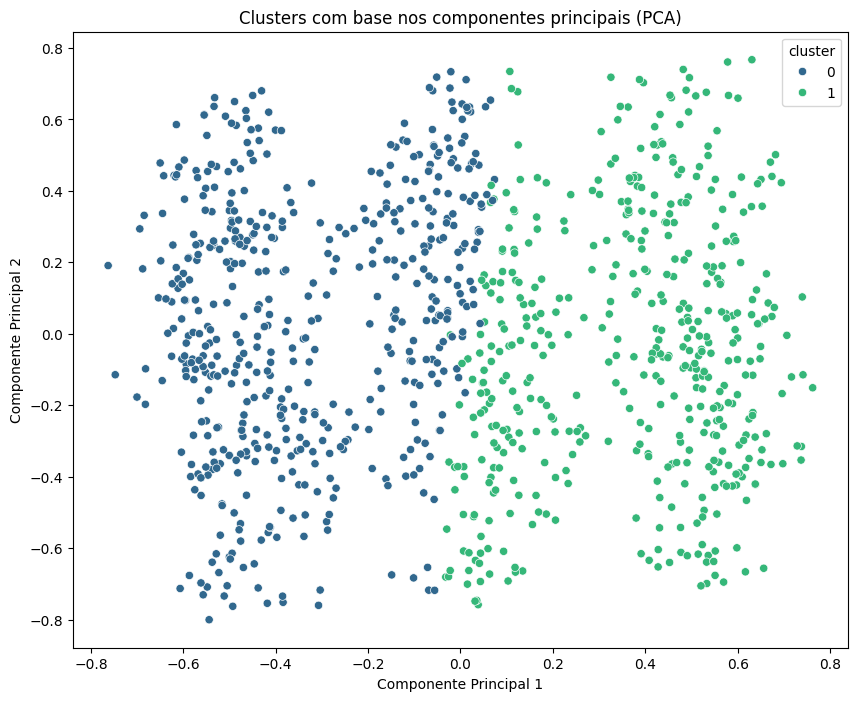

In [54]:
# Plotar o gráfico dos clusters com base nos componentes principais (PCA)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=dataset, palette='viridis')
plt.title('Clusters com base nos componentes principais (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [55]:
# Obter informações estatísticas para cada cluster
for cluster_id in dataset['cluster'].unique():
  cluster_data = dataset[dataset['cluster'] == cluster_id]
  print(f"\nInformações do Cluster {cluster_id}:")
  print(cluster_data.describe().to_string())


Informações do Cluster 0:
          ID_Venda                     Data_Venda  ID_Produto  Quantidade  Preco_Unitario   ID_Cliente    Valor_Total    Desconto       Frete  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded  ID_Venda_minmax  ID_Produto_minmax  Quantidade_minmax  Preco_Unitario_minmax  ID_Cliente_minmax  Valor_Total_minmax  Desconto_minmax  Frete_minmax  Canal_Venda_encoded_minmax  Forma_Pagamento_encoded_minmax  Regiao_encoded_minmax  Categoria_Produto_encoded_minmax         pc1         pc2  cluster
count   523.000000                            523  523.000000  523.000000      523.000000   523.000000     523.000000  523.000000  523.000000           523.000000               523.000000      523.000000                 523.000000       523.000000         523.000000         523.000000             523.000000         523.000000          523.000000       523.000000    523.000000                  523.000000                      523.000000      

## Etapa 10: Rotulagem

In [56]:
# Verificar se a coluna 'Venda' já existe no dataset
if 'Classe' not in dataset.columns:
  # Se não existir, criar a coluna e atribuir valores iniciais (por exemplo, 'N/A')
  dataset['Classe'] = 'N/A'

# Atualizar a coluna 'Venda' com base nos clusters
dataset.loc[dataset['cluster'] == 0, 'Classe'] = 'B'
dataset.loc[dataset['cluster'] == 1, 'Classe'] = 'A'

# Exibir o dataset com a coluna 'Venda' atualizada
print("Dataset com a coluna 'Venda' atualizada:")
print(dataset.head().to_string())

Dataset com a coluna 'Venda' atualizada:
   ID_Venda Data_Venda  ID_Produto  Quantidade  Preco_Unitario  ID_Cliente  Valor_Total   Canal_Venda         Forma_Pagamento  Desconto  Frete        Regiao Categoria_Produto  Canal_Venda_encoded  Forma_Pagamento_encoded  Regiao_encoded  Categoria_Produto_encoded  ID_Venda_minmax  ID_Produto_minmax  Quantidade_minmax  Preco_Unitario_minmax  ID_Cliente_minmax  Valor_Total_minmax  Desconto_minmax  Frete_minmax  Canal_Venda_encoded_minmax  Forma_Pagamento_encoded_minmax  Regiao_encoded_minmax  Categoria_Produto_encoded_minmax       pc1       pc2  cluster Classe
0         1 2023-06-22         168        56.0          291.26        1281     11723.54  Distribuidor                Dinheiro     28.20  12.56       Sudeste            Móveis                    0                        2               3                          3         0.000000           0.686869           0.074324               0.062115           0.281281            0.070159         0.941

## Etapa 11: Preparação dos Dados para o Aprendizado de Máquina

###  Balanceamento

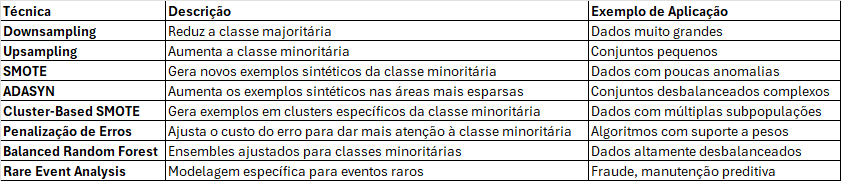

In [57]:
# Contar a quantidade de dados para cada classe
class_counts = dataset['Classe'].value_counts()
print("Quantidade de dados para cada classe:")
print(class_counts)

# Obter a classe minoritária
minority_class = class_counts.idxmin()
# Obter a classe majoritária
majority_class = class_counts.idxmax()

# Separar os dados em conjuntos de acordo com a classe
df_majority = dataset[dataset.Classe == majority_class]
df_minority = dataset[dataset.Classe == minority_class]

# Realizar o balanceamento por meio do método de reamostragem (upsampling/oversampling) da classe minoritária
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # Amostrar com reposição
                                 n_samples=len(df_majority),  # Número de amostras igual ao da classe majoritária
                                 random_state=42)  # Seed para reprodutibilidade

# Combinar os dados majoritários e os dados minoritários reamostrados
datasetx = pd.concat([df_majority, df_minority_upsampled])

# Verificar se o balanceamento foi realizado com sucesso
print("Quantidade de dados para cada classe após balanceamento:")
print(datasetx['Classe'].value_counts())

Quantidade de dados para cada classe:
Classe
B    523
A    470
Name: count, dtype: int64
Quantidade de dados para cada classe após balanceamento:
Classe
B    523
A    523
Name: count, dtype: int64


### Regras

In [58]:
# Definir as regras de atribuição para as colunas
column_rules = {
    datasetx.columns[0]: 'meta',  # Primeiro campo como meta
    'Classe': 'target',  # Coluna 'Classe' como target
    '*': 'feature'  # Todas as outras colunas como features
}

# Aplicar as regras às colunas do dataset
for column in dataset.columns:
  if column in column_rules:
    # Atribuir a regra específica para a coluna
    datasetx.attrs[column] = column_rules[column]
  else:
    # Atribuir a regra padrão ('feature')
    datasetx.attrs[column] = column_rules['*']

# Exibir as regras de atribuição
print("Regras de atribuição para as colunas:")
for column in dataset.columns:
    print(f"{column}: {datasetx.attrs[column]}")

Regras de atribuição para as colunas:
ID_Venda: meta
Data_Venda: feature
ID_Produto: feature
Quantidade: feature
Preco_Unitario: feature
ID_Cliente: feature
Valor_Total: feature
Canal_Venda: feature
Forma_Pagamento: feature
Desconto: feature
Frete: feature
Regiao: feature
Categoria_Produto: feature
Canal_Venda_encoded: feature
Forma_Pagamento_encoded: feature
Regiao_encoded: feature
Categoria_Produto_encoded: feature
ID_Venda_minmax: feature
ID_Produto_minmax: feature
Quantidade_minmax: feature
Preco_Unitario_minmax: feature
ID_Cliente_minmax: feature
Valor_Total_minmax: feature
Desconto_minmax: feature
Frete_minmax: feature
Canal_Venda_encoded_minmax: feature
Forma_Pagamento_encoded_minmax: feature
Regiao_encoded_minmax: feature
Categoria_Produto_encoded_minmax: feature
pc1: feature
pc2: feature
cluster: feature
Classe: target


### Seleção das Dimensões

In [59]:
# Criar um novo dataset com apenas a coluna 'target' e as features com sufixo '_minmax'
datasetx_new = datasetx[['Classe'] + [col for col in datasetx.columns if col.endswith('_minmax')]].copy()

# Exibir o novo dataset
print("Novo dataset com target e features '_minmax':")
print(datasetx_new.head().to_string())

Novo dataset com target e features '_minmax':
   Classe  ID_Venda_minmax  ID_Produto_minmax  Quantidade_minmax  Preco_Unitario_minmax  ID_Cliente_minmax  Valor_Total_minmax  Desconto_minmax  Frete_minmax  Canal_Venda_encoded_minmax  Forma_Pagamento_encoded_minmax  Regiao_encoded_minmax  Categoria_Produto_encoded_minmax
0       B         0.000000           0.686869           0.074324               0.062115           0.281281            0.070159         0.941137      0.168037                         0.0                        0.666667                   0.75                              0.75
3       B         0.003003           0.939394           0.027027               0.039635           0.576577            0.017774         0.837458      0.597466                         0.5                        0.666667                   0.75                              1.00
8       B         0.008008           0.030303           0.108108               0.017698           0.528529            0.038223   

### Separação dos Dados para Treinamento/Teste e Validação

In [60]:
# Separar os dados em treino e teste (80/20)
X = datasetx_new.drop('Classe', axis=1)
y = datasetx_new['Classe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Exibir o tamanho dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", len(X_train))
print(X_train.head().to_string())
print("Tamanho do conjunto de teste:", len(X_test))
print(X_test.head().to_string())

Tamanho do conjunto de treino: 836
     ID_Venda_minmax  ID_Produto_minmax  Quantidade_minmax  Preco_Unitario_minmax  ID_Cliente_minmax  Valor_Total_minmax  Desconto_minmax  Frete_minmax  Canal_Venda_encoded_minmax  Forma_Pagamento_encoded_minmax  Regiao_encoded_minmax  Categoria_Produto_encoded_minmax
772         0.772773           0.191919           0.054054               0.014605           0.900901            0.014525         0.707358      0.124472                         0.5                        0.666667                    0.0                              0.00
873         0.873874           0.898990           0.074276               0.095407           0.884885            0.081924         0.319732      0.796621                         1.0                        1.000000                    1.0                              0.00
8           0.008008           0.030303           0.108108               0.017698           0.528529            0.038223         0.419064      0.479218       

## Etapa 12: Escolha dos Hiperparâmetros dos Modelos

### Abordagem Neural ou Conexionista

[Explicação do MLP:](https://youtu.be/oivb9285i54)

In [61]:
# Definir os hiperparâmetros para o modelo MultiLayer Perceptron
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Número de neurônios em cada camada oculta
    'activation': ['relu', 'tanh', 'logistic'],  # Função de ativação
    'solver': ['adam', 'sgd'],  # Algoritmo de otimização
    'alpha': [0.0001, 0.001, 0.01],  # Parâmetro de regularização L2
    'learning_rate': ['constant', 'adaptive'],  # Taxa de aprendizado
    'learning_rate_init': [0.001, 0.01],  # Taxa de aprendizado inicial
    'max_iter': [200, 500],  # Número máximo de iterações
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

[Explicação do CNN:](https://youtu.be/QM1kjB03cYk)

In [62]:
# Definir os hiperparâmetros para o modelo Convolutional Neural Network
cnn_params = {
    'filters': [32, 64, 128],  # Número de filtros em cada camada convolucional
    'kernel_size': [3, 5],  # Tamanho do kernel (núcleo) da convolução
    'activation': ['relu'],  # Função de ativação nas camadas convolucionais
    'pooling': ['max'],  # Tipo de pooling (max pooling ou average pooling)
    'dropout': [0.0, 0.2, 0.5],  # Taxa de dropout para regularização
    'dense_units': [64, 128],  # Número de neurônios na camada densa
    'optimizer': ['adam', 'rmsprop'],  # Otimizador para treinamento
    'loss': ['binary_crossentropy'],  # Função de perda
    'metrics': ['accuracy'],  # Métricas para avaliação
    'epochs': [10, 20, 30],  # Número de épocas de treinamento
    'batch_size': [32, 64, 128],  # Tamanho do lote para treinamento
}

[Explicação das GenAIs:](https://youtu.be/jzQhtxMKDQU)

In [63]:
# Definir os hiperparâmetros para o modelo Redes Autoencoders
ae_params = {
    'input_dim': X_train.shape[1],  # Dimensão da entrada (número de features)
    'hidden_layers': [64, 32, 16],  # Número de neurônios em cada camada oculta
    'latent_dim': 8,  # Dimensão do espaço latente (tamanho do código)
    'activation': 'relu',  # Função de ativação das camadas ocultas
    'optimizer': 'adam',  # Otimizador para treinamento
    'loss': 'mse',  # Função de perda (erro quadrático médio)
    'epochs': 100,  # Número de épocas de treinamento
    'batch_size': 32,  # Tamanho do lote para treinamento
}

### Abordagem em Árvore

[Explicação do TD:](https://youtu.be/cbL1u4z4N3M)

In [64]:
# Definir os hiperparâmetros para o modelo Decision Tree
dt_params = {
    'criterion': ['gini', 'entropy'],  # Função para medir a qualidade da divisão
    'splitter': ['best', 'random'],  # Estratégia para escolher a divisão em cada nó
    'max_depth': [None, 5, 10, 15, 20],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras necessárias em cada folha
    'max_features': [None, 'sqrt', 'log2'],  # Número de features a serem consideradas para cada divisão
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

[Explicação do RF:](https://youtu.be/ByUoVg4QI84)

In [65]:
# Definir os hiperparâmetros para o modelo Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],  # Número de árvores na floresta
    'criterion': ['gini', 'entropy'],  # Função para medir a qualidade da divisão
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt', 'log2'],  # Número máximo de features a serem consideradas para dividir um nó
    'bootstrap': [True, False],  # Usar bootstrap para criar as amostras para as árvores
    'class_weight': ['balanced', None],  # Tratamento de classes desbalanceadas
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

In [66]:
# Definir os hiperparâmetros para o modelo Light Gradient Boosting Machine
lgbm_params = {
    'learning_rate': [0.01, 0.1, 0.2],  # Taxa de aprendizado
    'n_estimators': [50, 100, 200],  # Número de estimadores (árvores)
    'max_depth': [3, 5, 7],  # Profundidade máxima da árvore
    'num_leaves': [31, 63, 127],  # Número máximo de folhas em cada árvore
    'boosting_type': ['gbdt', 'dart'],  # Tipo de boosting
    'objective': ['binary'],  # Função objetivo (classificação binária)
    'metric': ['binary_logloss', 'auc'],  # Métricas para avaliar o modelo
    'subsample': [0.8, 1.0],  # Fração de amostras usadas para treinamento de cada árvore
    'colsample_bytree': [0.8, 1.0],  # Fração de features usadas para treinamento de cada árvore
    'reg_alpha': [0, 0.1, 0.5],  # Regularização L1
    'reg_lambda': [0, 0.1, 0.5],  # Regularização L2
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

### Abordagem Estatística

[Explicação do SVM:](https://youtu.be/UrR5tcY-wYw)

In [67]:
# Definir os hiperparâmetros para o modelo Support Vector Machine
svm_params = {
    'C': [0.1, 1, 10, 100],  # Parâmetro de regularização
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Parâmetro do kernel RBF, polinomial e sigmoid
    'degree': [2, 3, 4],  # Grau do kernel polinomial
    'class_weight': ['balanced', None],  # Tratamento de classes desbalanceadas
}

[Explicação do KNN:](https://youtu.be/oafK8OGu_Vk)

In [68]:
# Definir os hiperparâmetros para o modelo K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vizinhos mais próximos
    'weights': ['uniform', 'distance'],  # Tipo de ponderação dos vizinhos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para calcular os vizinhos mais próximos
    'leaf_size': [10, 20, 30, 40],  # Tamanho das folhas para ball_tree e kd_tree
    'p': [1, 2]  # Parâmetro da métrica de distância (1 para distância de Manhattan, 2 para distância euclidiana)
}

[Explicação do LOR:](https://youtu.be/zFdVFTd-Y50)

In [69]:
# Definir os hiperparâmetros para o modelo Logistic Regression
lor_params = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Tipo de regularização
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parâmetro de regularização (inverso da força da regularização)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algoritmo para otimização
    'max_iter': [100, 200, 300],  # Número máximo de iterações
    'multi_class': ['auto', 'ovr', 'multinomial'],  # Método para lidar com problemas multiclasse
}

### Otimização dos Hiperparâmetros

In [70]:
# Criar um dicionário com os modelos e seus hiperparâmetros correspondentes
#models = {
#    'MLP': (MLPClassifier(), mlp_params),
#    'DT': (DecisionTreeClassifier(), dt_params),
#    'RF': (RandomForestClassifier(), rf_params),
#    'LGBM': (LGBMClassifier(), lgbm_params),
#    'SVM': (SVC(), svm_params),
#    'KNN': (KNeighborsClassifier, knn_params),
#    'LOR': (LogisticRegression(), lor_params)
#}

# Criar um dicionário com os modelos e seus hiperparâmetros correspondentes
models = {
    'MLP': (MLPClassifier(), mlp_params),
    'RF': (RandomForestClassifier(), rf_params),
    'SVM': (SVC(), svm_params)
}

# Definir a estratégia de validação cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop para otimizar os hiperparâmetros de cada modelo
for model_name, (model, params) in models.items():
    print(f"Otimizando hiperparâmetros para o modelo: {model_name}")

    # Criar o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)

    # Ajustar o GridSearchCV aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprimir os melhores hiperparâmetros encontrados
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

    # Avaliar o modelo com os melhores hiperparâmetros no conjunto de teste
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calcular as métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Métricas para {model_name} com melhores hiperparâmetros:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Salvar o modelo com os melhores hiperparâmetros (opcional)
    filename = f'{model_name}_best_model.pkl'
    pickle.dump(best_model, open(filename, 'wb'))

Otimizando hiperparâmetros para o modelo: MLP


KeyboardInterrupt: 

## Etapa 13: Competição de Modelos

### Multilayer Perceptron (MLP)

In [71]:
# Criar um modelo MLP com hiperparâmetros específicos
mlp_model = MLPClassifier(
    hidden_layer_sizes=(32,16),  # Número de neurônios em cada camada oculta
    activation='relu',  # Função de ativação
    solver='adam',  # Algoritmo de otimização
    alpha=0.0001,  # Termo de regularização L2
    batch_size='auto',  # Tamanho do batch para o treinamento
    learning_rate='constant',  # Taxa de aprendizado
    learning_rate_init=0.001,  # Taxa de aprendizado inicial
    power_t=0.5,  # Parâmetro para o algoritmo de otimização 'sgd'
    max_iter=200,  # Número máximo de iterações
    shuffle=True,  # Embaralhar os dados a cada época
    random_state=None,  # Semente aleatória
    tol=0.0001,  # Tolerância para o critério de parada
    verbose=False,  # Mostrar mensagens durante o treinamento
    warm_start=False,  # Reutilizar a solução da inicialização anterior
    momentum=0.9,  # Parâmetro para o algoritmo de otimização 'sgd'
    nesterovs_momentum=True,  # Utilizar o momentum de Nesterov
    early_stopping=False,  # Parar o treinamento precocemente
    validation_fraction=0.1,  # Fração de dados para validação
    beta_1=0.9,  # Parâmetro para o algoritmo de otimização 'adam'
    beta_2=0.999,  # Parâmetro para o algoritmo de otimização 'adam'
    epsilon=1e-08,  # Parâmetro para o algoritmo de otimização 'adam'
    n_iter_no_change=10,  # Número máximo de épocas sem melhoria
    max_fun=1000  # Número máximo de chamadas para a função de custo
)

# Exibir os hiperparâmetros
print("Hiperparâmetros do modelo MLP:")
print(mlp_model.get_params())

Hiperparâmetros do modelo MLP:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (32, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 1000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [72]:
# Treinar e avaliar o modelo com validação cruzada
cv_scores = cross_val_score(mlp_model, X_train, y_train, cv=3, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Resultados da validação cruzada para o modelo:")
print("Acurácia para cada fold:", cv_scores)
print("Acurácia média:", cv_scores.mean())
print("Desvio padrão da acurácia:", cv_scores.std())

# Treinar o modelo com os dados de treinamento completos
mlp_model.fit(X_train, y_train)

# Fazer previsões com o modelo no conjunto de teste
y_pred_mlp = mlp_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultados da validação cruzada para o modelo:
Acurácia para cada fold: [0.99283154 0.98924731 0.99280576]
Acurácia média: 0.9916282028140929
Desvio padrão da acurácia: 0.001683577073389385


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Light Gradient Boosting Machine (LGBM)

In [73]:
# Criar um modelo LGBM com hiperparâmetros específicos
lgbm_model = LGBMClassifier(
    learning_rate=0.1,  # Taxa de aprendizado
    n_estimators=100,  # Número de estimadores (árvores)
    max_depth=7,  # Profundidade máxima da árvore
    num_leaves=127,  # Número máximo de folhas em cada árvore
    boosting_type='gbdt',  # Tipo de boosting
    objective='binary',  # Função objetivo (classificação binária)
    metric='binary_logloss',  # Métricas para avaliar o modelo
    subsample=0.8,  # Fração de amostras usadas para treinamento de cada árvore
    colsample_bytree=0.8,  # Fração de features usadas para treinamento de cada árvore
    reg_alpha=0.1,  # Regularização L1
    reg_lambda=0.1,  # Regularização L2
    random_state=42  # Seed para reprodutibilidade dos resultados
)

# Exibir os hiperparâmetros
print("Hiperparâmetros do modelo LGBM:")
print(lgbm_model.get_params())

Hiperparâmetros do modelo LGBM:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 127, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'binary_logloss'}


In [74]:
# Treinar e avaliar o modelo com validação cruzada
cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=3, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Resultados da validação cruzada para o modelo LGBM:")
print("Acurácia para cada fold:", cv_scores)
print("Acurácia média:", cv_scores.mean())
print("Desvio padrão da acurácia:", cv_scores.std())

# Treinar o modelo com os dados de treinamento completos
lgbm_model.fit(X_train, y_train)

# Fazer previsões com o modelo no conjunto de teste
y_pred_lgbm = lgbm_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

[LightGBM] [Info] Number of positive: 279, number of negative: 278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500898 -> initscore=0.003591
[LightGBM] [Info] Start training from score 0.003591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Support Vector Machine (SVM)

In [75]:
# Criar modelo SVM com hiperparâmetros específicos
svm_model = SVC(
    C=1.0,  # Parâmetro de regularização (custo da classificação incorreta)
    kernel='rbf',  # Kernel para o modelo (radial basis function)
    degree=3,  # Grau do polinômio para o kernel (relevante para kernel='poly')
    gamma='scale',  # Coeficiente do kernel (relevante para kernel='rbf', 'poly', 'sigmoid')
    coef0=0.0,  # Termo independente para o kernel (relevante para kernel='poly', 'sigmoid')
    shrinking=True,  # Utilização do shrinking heuristic para otimizar a solução
    probability=False,  # Calcular probabilidades de classe
    tol=0.001,  # Tolerância para a otimização
    cache_size=200,  # Tamanho do cache em MB
    class_weight=None,  # Pesos para as classes (pode ser usado para lidar com classes desbalanceadas)
    verbose=False,  # Mostrar mensagens durante a execução
    max_iter=200,  # Número máximo de iterações para a otimização (-1 significa ilimitado)
    decision_function_shape='ovr',  # Formato da função de decisão ('ovo' para one-vs-one, 'ovr' para one-vs-rest)
    break_ties=False,  # Quebrar empates com maior precisão (relevante para classificação multiclasse)
    random_state=None  # Semente aleatória para reprodutibilidade
)

# Exibir os hiperparâmetros
print("Hiperparâmetros do modelo SVM:")
print(svm_model.get_params())

Hiperparâmetros do modelo SVM:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 200, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [76]:
# Treinar e avaliar o modelo com validação cruzada
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=3, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Resultados da validação cruzada para o modelo:")
print("Acurácia para cada fold:", cv_scores)
print("Acurácia média:", cv_scores.mean())
print("Desvio padrão da acurácia:", cv_scores.std())

# Treinar o modelo com os dados de treinamento completos
svm_model.fit(X_train, y_train)

# Fazer previsões com o modelo no conjunto de teste
y_pred_svm = svm_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy_svm = accuracy_score(y_test, y_pred_mlp)
precision_svm = precision_score(y_test, y_pred_mlp, average='weighted')
recall_svm = recall_score(y_test, y_pred_mlp, average='weighted')
f1_svm = f1_score(y_test, y_pred_mlp, average='weighted')

Resultados da validação cruzada para o modelo:
Acurácia para cada fold: [0.98566308 0.97849462 0.98561151]
Acurácia média: 0.9832564056281856
Desvio padrão da acurácia: 0.0033671541467787175


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Avaliação das Métricas

In [77]:
# Imprimir as métricas de avaliação para o modelo
print("\nMétricas de avaliação para o modelo MLP:")
print("Acurácia:", accuracy_mlp)
print("Precisão:", precision_mlp)
print("Revocação:", recall_mlp)
print("Mensuraçao:", f1_mlp)

# Imprimir as métricas de avaliação para o modelo
print("\nMétricas de avaliação para o modelo LGBM:")
print("Acurácia:", accuracy_lgbm)
print("Precisão:", precision_lgbm)
print("Revocação:", recall_lgbm)
print("Mensuraçao:", f1_lgbm)

# Imprimir as métricas de avaliação para o modelo
print("\nMétricas de avaliação para o modelo SVM:")
print("Acurácia:", accuracy_svm)
print("Precisão:", precision_svm)
print("Revocação:", recall_svm)
print("Mensuraçao:", f1_svm)


Métricas de avaliação para o modelo MLP:
Acurácia: 0.9857142857142858
Precisão: 0.9857583454281568
Revocação: 0.9857142857142858
Mensuraçao: 0.9857139617678404

Métricas de avaliação para o modelo LGBM:
Acurácia: 0.9809523809523809
Precisão: 0.9811269394791761
Revocação: 0.9809523809523809
Mensuraçao: 0.9809506531204645

Métricas de avaliação para o modelo SVM:
Acurácia: 0.9857142857142858
Precisão: 0.9857583454281568
Revocação: 0.9857142857142858
Mensuraçao: 0.9857139617678404


In [78]:
# Criar um DataFrame para armazenar as métricas de cada modelo
metricas_modelos = pd.DataFrame({
    'Modelo': ['MLP', 'LGBM', 'SVM'],
    'Acurácia': [accuracy_mlp, accuracy_lgbm, accuracy_svm],
    'Precisão': [precision_mlp, precision_lgbm, precision_svm],
    'Revocação': [recall_mlp, recall_lgbm, recall_svm],
    'Mensuração': [f1_mlp, f1_lgbm, f1_svm]
})

# Exibir as métricas de cada modelo
print("\nMétricas dos Modelos:")
print(metricas_modelos)

# Encontrar o modelo com a maior acurácia
melhor_modelo_acuracia = metricas_modelos.loc[metricas_modelos['Acurácia'].idxmax()]
print(f"\nMelhor modelo com base na Acurácia: {melhor_modelo_acuracia['Modelo']}")

# Encontrar o modelo com o maior Precisão
melhor_modelo_precisao = metricas_modelos.loc[metricas_modelos['Precisão'].idxmax()]
print(f"\nMelhor modelo com base no Precisão: {melhor_modelo_precisao['Modelo']}")

# Encontrar o modelo com o maior Revocação
melhor_modelo_revocacao = metricas_modelos.loc[metricas_modelos['Revocação'].idxmax()]
print(f"\nMelhor modelo com base no Revocação: {melhor_modelo_precisao['Modelo']}")

# Encontrar o modelo com o maior Mensuração
melhor_modelo_mensuracao = metricas_modelos.loc[metricas_modelos['Mensuração'].idxmax()]
print(f"\nMelhor modelo com base no Mensuração: {melhor_modelo_mensuracao['Modelo']}")

# Avaliar o melhor modelo com base em múltiplas métricas (exemplo: média ponderada de Acurácia e F1-Score)
metricas_modelos['Pontuacao_Media'] = (metricas_modelos['Acurácia'] + metricas_modelos['Precisão']  + metricas_modelos['Revocação'] + metricas_modelos['Mensuração']) / 4
melhor_modelo_media = metricas_modelos.loc[metricas_modelos['Pontuacao_Media'].idxmax()]
print(f"\nMelhor modelo com base na média ponderada de Acurácia, Precisão, Revocação e Mensuração: {melhor_modelo_media['Modelo']}")



Métricas dos Modelos:
  Modelo  Acurácia  Precisão  Revocação  Mensuração
0    MLP  0.985714  0.985758   0.985714    0.985714
1   LGBM  0.980952  0.981127   0.980952    0.980951
2    SVM  0.985714  0.985758   0.985714    0.985714

Melhor modelo com base na Acurácia: MLP

Melhor modelo com base no Precisão: MLP

Melhor modelo com base no Revocação: MLP

Melhor modelo com base no Mensuração: MLP

Melhor modelo com base na média ponderada de Acurácia, Precisão, Revocação e Mensuração: MLP


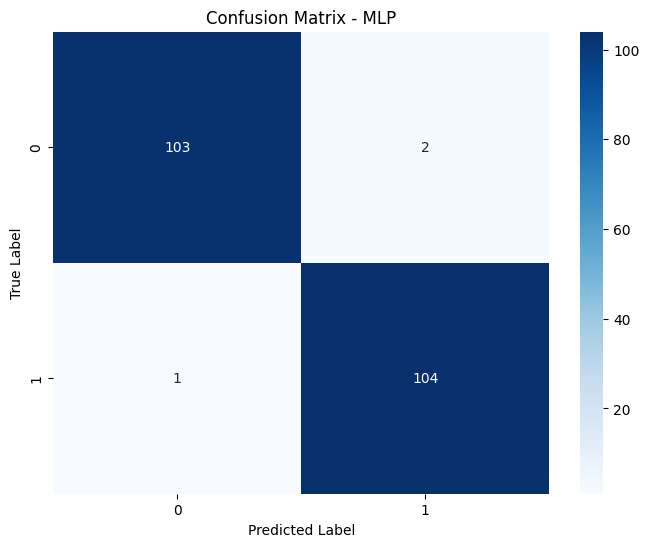

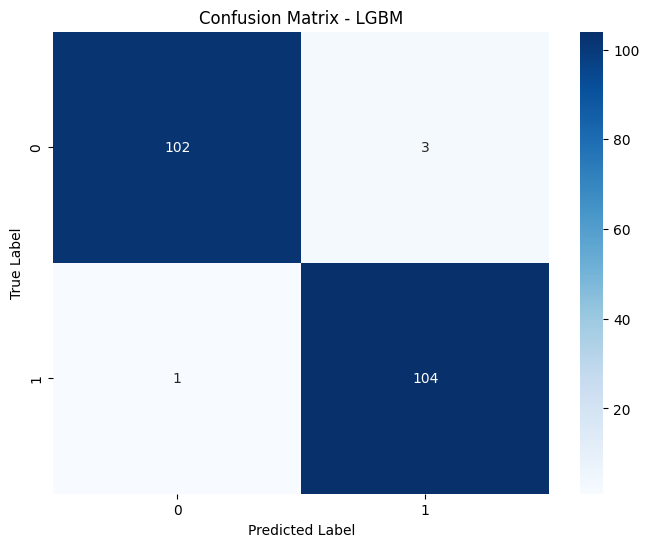

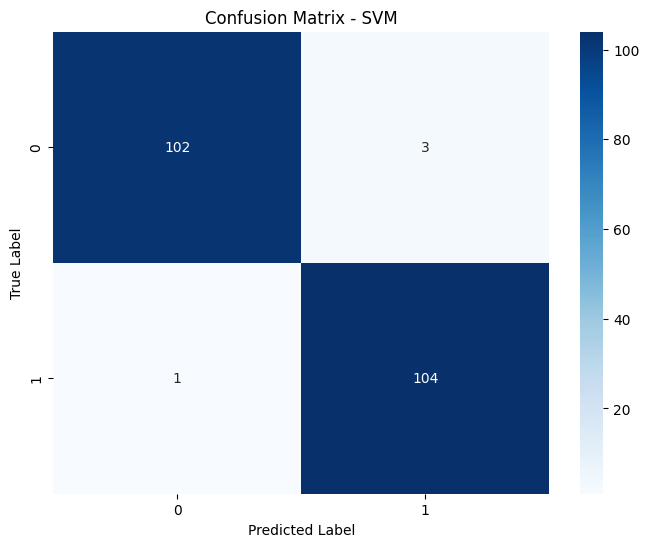

In [79]:
# Gerar matrizes de confusão para cada modelo
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Função para plotar matriz de confusão
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Matrizes de confusão de plotagem para cada modelo
plot_confusion_matrix(cm_mlp, 'MLP')
print()
plot_confusion_matrix(cm_lgbm, 'LGBM')
print()
plot_confusion_matrix(cm_svm, 'SVM')

### Salvar Modelo Campeão

In [80]:
# Salvar o modelo campeão treinado
filename = 'model.pkl'
pickle.dump(mlp_model, open(filename, 'wb'))

## Etapa 14: Produção (Deploy)

### Modelo

In [81]:
# Carregar o modelo salvo
filename = 'model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

### Validando o modelo

Métricas do modelo carregado:
Acurácia: 0.9857
Precisão: 0.9858
Recall: 0.9857
F1-Score: 0.9857


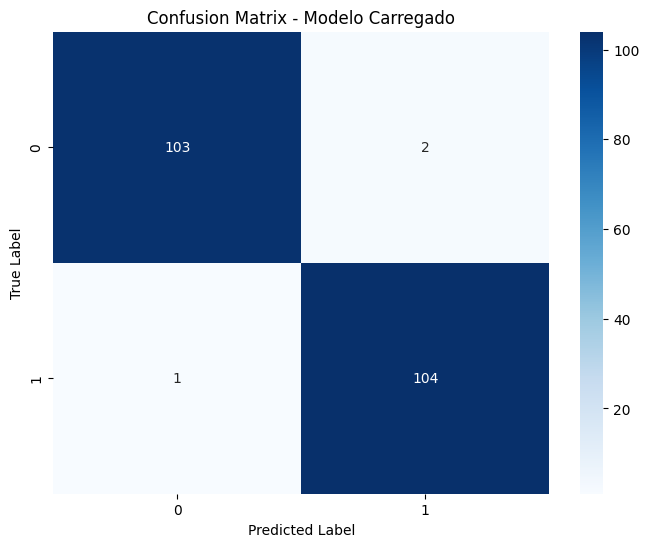

In [82]:
# Carregar o modelo salvo (substitua 'model.pkl' pelo nome do arquivo do seu modelo)
filename = 'model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

# Fazer previsões com o modelo carregado no conjunto de teste
y_pred = loaded_model.predict(X_test)

# Calcular as métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Métricas do modelo carregado:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão (opcional)
plot_confusion_matrix(cm, 'Modelo Carregado')